# SOTA-AI Monthly Challenge — Task 2: Kartik’s Misty Problem

This notebook presents an end-to-end solution for **vehicle and pedestrian detection in foggy road scenes** under severe visibility degradation. The core challenge lies in handling **domain shift**: the training dataset consists of clear, sunny-day images, while the test set contains heavily fog-obscured scenes resembling CCTV footage.

To address this, the solution adopts a **domain adaptation strategy via physically inspired fog simulation**, applied offline to the training data. The approach emphasizes:
- Realistic atmospheric degradation (fog density, depth bias, patchiness)
- Preservation of object geometry and class structure
- Recall-oriented inference aligned with the **Detection Quality Index (DQI)** metric

The final pipeline includes:
1. Dataset preparation and fog-based domain adaptation
2. YOLOv8-based object detection training
3. Recall-aware inference and robust submission generation

With the refined fog model and tuned inference strategy, this approach achieved a **DQI score of 0.49504**, placing it at the **top of the leaderboard** at the time of submission.


## 1. Imports and Environment Setup

This section initializes all required libraries and dependencies used throughout the notebook.  
The solution relies on a combination of:

- **Ultralytics YOLOv8** for object detection
- **OpenCV** for image processing and fog simulation
- **NumPy** for numerical operations
- **Pandas** for dataset handling and submission generation
- **Matplotlib** for visual inspection and sanity checks

All experiments were conducted using a GPU-enabled environment (NVIDIA T4 on Google Colab).


In [ ]:
# Installing the necessary libraries

!pip install -U ultralytics opencv-python-headless pandas tqdm pyyaml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 139.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
# Importing the necessary libraries

import os, cv2, yaml, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Setting up the legacy Kaggle API and downloading the dataset

!pip install kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c kartiks-misty-problem

!unzip kartiks-misty-problem.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Train/images/Highway_1749_2020-07-30_jpg.rf.7ce3c6c94d5e7454804b890ea39746dc.jpg  
  inflating: Train/Train/images/Highway_1749_2020-07-30_jpg.rf.ce14a5d88cff15ddfc740b90285c6225.jpg  
  inflating: Train/Train/images/Highway_174_2020-07-30_jpg.rf.7468e056403a068d7bd02100e2df6f6c.jpg  
  inflating: Train/Train/images/Highway_174_2020-07-30_jpg.rf.bf5d534fba088b43c5131a6f75126268.jpg  
  inflating: Train/Train/images/Highway_1750_2020-07-30_jpg.rf.c410032218366a4eda7c906798ab1744.jpg  
  inflating: Train/Train/images/Highway_1751_2020-07-30_jpg.rf.56f748d2acda2572f03b70e159372f1f.jpg  
  inflating: Train/Train/images/Highway_1752_2020-07-30_jpg.rf.260064df0741aa0fd7c3accbe3fb124f.jpg  
  inflating: Train/Train/images/Highway_1754_2020-07-30_jpg.rf.d8d123b06ef57aab8640ca90d721a545.jpg  
  inflating: Train/Train/images/Highway_1755_2020-07-30_jpg.rf.9d264d32644b43694c6826d85e6dbe8a.jpg  
  inflating: Train/Train/images/H

In [ ]:
# Preparing the dataset directories required for YOLOv8 training

os.makedirs("dataset/images/train_clear", exist_ok=True)
os.makedirs("dataset/images/test", exist_ok=True)
os.makedirs("dataset/labels/train", exist_ok=True)

# copy images
os.system("cp Train/Train/images/* dataset/images/train_clear/")
os.system("cp Test/* dataset/images/test/")


0

In [ ]:
print(len(os.listdir('/content/dataset/images/train_clear')))

print(len(os.listdir('/content/dataset/images/test')))

8025
3393


## 2. Dataset Preparation via Artificial Fog Simulation

A key challenge in this task is the **domain gap** between clear training images and foggy test images.  
Rather than relying solely on online data augmentation during training, this solution performs **offline fog simulation** to explicitly align the training distribution with the test domain.

### Design Principles of the Fog Model

The fog simulation is designed to closely resemble real-world fog observed in the test set:
- **Global atmospheric haze** reduces overall visibility
- **Depth-aware fog density** increases with distance from the camera
- **Patchy, low-frequency fog variations** mimic uneven fog distribution
- **Mild desaturation** drains color without converting images to grayscale
- **Subtle blur and sensor noise** simulate CCTV-like imaging artifacts

This preprocessing step produces fog-adapted training images while preserving original object labels, enabling robust domain-adaptive learning.


In [ ]:
# Read the training annotations provided as a CSV file.
# Each row corresponds to ONE image, but may contain MULTIPLE objects
# encoded as comma-separated lists (classes and bounding box parameters).
df = pd.read_csv("train.csv")

# Iterate over every image entry in the CSV
for _, row in tqdm(df.iterrows(), total=len(df)):
    # Image identifier (used to name the YOLO label file)
    img_id = str(row["Id"])

    # Parse comma-separated object annotations
    classes = list(map(int, row["Classes"].split(",")))
    xs = list(map(float, row["X_center"].split(",")))
    ys = list(map(float, row["Y_center"].split(",")))
    ws = list(map(float, row["Width"].split(",")))
    hs = list(map(float, row["Height"].split(",")))

    # Create one YOLO-format label file per image.
    # YOLO expects: <class_id> <x_center> <y_center> <width> <height>
    label_path = f"dataset/labels/train/{img_id}.txt"

    with open(label_path, "w") as f:
        # Write one line per object instance in the image
        for c, x, y, w, h in zip(classes, xs, ys, ws, hs):
            f.write(f"{c} {x} {y} {w} {h}\n")


100%|██████████| 8025/8025 [00:02<00:00, 2724.69it/s]


In [ ]:
!head dataset/labels/train/*.txt


Streaming output truncated to the last 5000 lines.
2 0.652644 0.581731 0.050481 0.158654
9 0.415865 0.401442 0.096154 0.370192

==> dataset/labels/train/ulu2532_jpg.rf.292efd09e6a8c70116b504be64b3a142.txt <==
4 0.503606 0.206731 0.036058 0.0625
9 0.59976 0.530048 0.194712 0.564904
0 0.413462 0.477163 0.115385 0.290865
4 0.50601 0.296875 0.036058 0.084135
2 0.697115 0.430288 0.028846 0.091346
2 0.780048 0.567308 0.040865 0.115385

==> dataset/labels/train/ulu2533_jpg.rf.657f8ac2d1087cf6abcfe1a0271cdd34.txt <==
4 0.515625 0.544471 0.084135 0.194712
2 0.754808 0.411058 0.048077 0.0625

==> dataset/labels/train/ulu2534_jpg.rf.2a44e4b10274a4703156b70f879c2f4b.txt <==
4 0.436298 0.475962 0.088942 0.163462
2 0.723558 0.807692 0.081731 0.221154
2 0.564904 0.288462 0.024038 0.072115

==> dataset/labels/train/ulu2535_jpg.rf.a1c5c109784b41db7c441c5ad2d89f6c.txt <==
2 0.56851 0.373798 0.03125 0.103365
2 0.647837 0.617788 0.045673 0.177885
2 0.813702 0.520433 0.040865 0.108173
9 0.444712 0.263221 0

In [ ]:
# Selecting a random image from training and test sets to visualize

train_img_dir = "dataset/images/train_clear"
test_img_dir = "dataset/images/test"

clear_img_filename = random.choice(os.listdir(train_img_dir))
clear_img = cv2.imread(os.path.join(train_img_dir, clear_img_filename))
clear_img = cv2.cvtColor(clear_img, cv2.COLOR_BGR2RGB)

test_img_filename = random.choice(os.listdir(test_img_dir))
test_img = cv2.imread(os.path.join(test_img_dir, test_img_filename))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

## 3. Fog Transformation Methodology

The fog simulation is implemented as a physically inspired image transformation that approximates atmospheric scattering and visibility loss.

Key components of the transformation include:
- **Depth bias**: Objects farther from the camera are more heavily obscured
- **Exponential transmittance modeling**: Inspired by optical fog models
- **Airlight blending**: Introduces washed-out brightness common in foggy scenes
- **Large-scale fog patches**: Adds spatial non-uniformity
- **Controlled desaturation**: Reduces color intensity without eliminating chromatic information

The parameters were tuned empirically through visual comparison with the test set to achieve a realistic fog impression without over-degrading object structure.


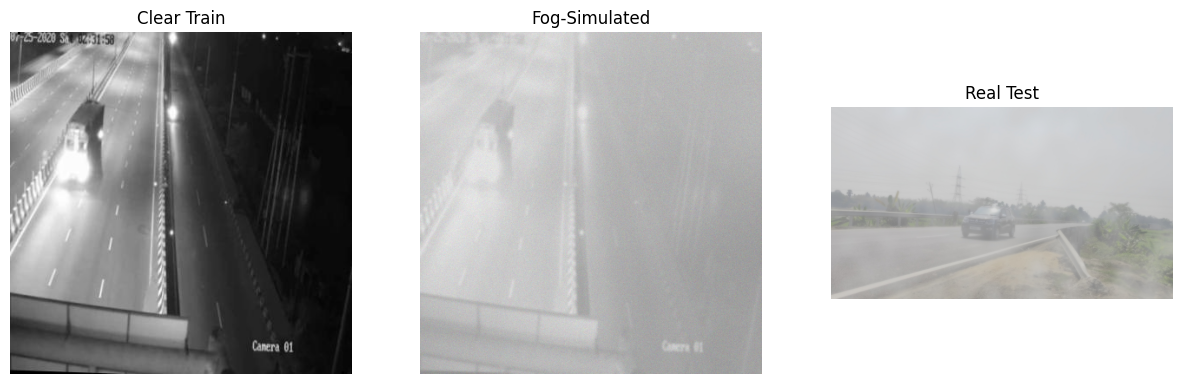

In [ ]:
# Function to simulate fog effect on a clear image and visualizing the results to strike the balance between realism and clarity.

def fog_transform(
    img,
    fog_strength=1.3,      # base fog (global)
    distance_boost=0.55,    # ~10% more fog in distance
    airlight=220,
    desat=0.15,
    blur_ksize=5,
    noise_std=4
):
    img = img.astype(np.float32)
    h, w, _ = img.shape

    # --------------------------------------------------
    # 1. Smooth depth bias (top = far)
    # --------------------------------------------------
    y = np.linspace(1, 0, h)
    depth = np.tile(y[:, None], (1, w))
    depth = depth ** 1.3   # smooth, horizon-heavy

    # --------------------------------------------------
    # 2. Large-scale fog patches (low-frequency)
    # --------------------------------------------------
    fog_noise = np.random.rand(h, w).astype(np.float32)
    fog_noise = cv2.GaussianBlur(fog_noise, (201, 201), 0)
    fog_noise = cv2.normalize(
        fog_noise, None, 0.8, 1.0, cv2.NORM_MINMAX
    )

    # --------------------------------------------------
    # 3. Global fog + gentle distance emphasis
    # --------------------------------------------------
    fog_factor = fog_strength * (1 + distance_boost * depth)
    t = np.exp(-fog_factor * fog_noise)
    t = t[..., None]

    # --------------------------------------------------
    # 4. Atmospheric blending
    # --------------------------------------------------
    A = np.ones_like(img) * airlight
    img = img * t + A * (1 - t)

    # --------------------------------------------------
    # 5. Mild blur (keeps immersion uniform)
    # --------------------------------------------------
    img = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)

    # --------------------------------------------------
    # 6. Soft desaturation
    # --------------------------------------------------
    gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    gray = np.stack([gray]*3, axis=-1)
    img = img * (1 - desat) + gray * desat

    # --------------------------------------------------
    # 7. Sensor noise
    # --------------------------------------------------
    img += np.random.normal(0, noise_std, img.shape)

    return np.clip(img, 0, 255).astype(np.uint8)


foggy = fog_transform(clear_img)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Clear Train"); plt.imshow(clear_img); plt.axis("off")
plt.subplot(1,3,2); plt.title("Fog-Simulated"); plt.imshow(foggy); plt.axis("off")
plt.subplot(1,3,3); plt.title("Real Test"); plt.imshow(test_img); plt.axis("off")
plt.show()

In [ ]:
# Mapping the images in dataset with the fog simulation function to create foggy images for training.

os.makedirs("dataset/images/train_fog", exist_ok=True)

for img_name in tqdm(os.listdir("dataset/images/train_clear")):
    img = cv2.imread(f"dataset/images/train_clear/{img_name}")
    foggy = fog_transform(img)
    cv2.imwrite(f"dataset/images/train_fog/{img_name}", foggy)


100%|██████████| 8025/8025 [28:15<00:00,  4.73it/s]


In [ ]:
print(len(os.listdir('dataset/images/train_fog')))

8025


In [ ]:
import shutil, os

# Remove broken train dir if it exists
if os.path.exists("dataset/images/train"):
    shutil.rmtree("dataset/images/train")

os.makedirs("dataset/images/train", exist_ok=True)


In [ ]:
# Moving the foggy images in train directory

import shutil, os
from tqdm import tqdm

fog_dir = "dataset/images/train_fog"
train_dir = "dataset/images/train"

for img in tqdm(os.listdir(fog_dir)):
    shutil.copy(
        os.path.join(fog_dir, img),
        os.path.join(train_dir, img)
    )


100%|██████████| 8025/8025 [00:08<00:00, 893.35it/s]


In [ ]:
# Moving the clear images in train directory with modified names

clear_dir = "dataset/images/train_clear"

for img in tqdm(os.listdir(clear_dir)):
    name, ext = os.path.splitext(img)
    new_name = f"{name}_clear{ext}"
    print(new_name)

    shutil.copy(
        os.path.join(clear_dir, img),
        os.path.join(train_dir, new_name)
    )


  0%|          | 1/8025 [00:00<26:14,  5.10it/s]

1610_clear.jpg
ulu684_jpg.rf.dafc210cb9e2a7828d951bf05a9030a1_clear.jpg
2526_clear.jpg


  0%|          | 27/8025 [00:00<01:17, 103.45it/s]

1224_clear.jpg
Highway_1239_2020-07-30_jpg.rf.a31408bee7ce93c45760f4e02de3d857_clear.jpg
Highway_827_2020-07-30_jpg.rf.2a2b97774b961c297d8f036c99bf2c89_clear.jpg
ulu2606_jpg.rf.b1e671f50f54d83824cc1d681f9040b4_clear.jpg
Highway_872_2020-07-30_jpg.rf.7b7b0e104a59659856ca4b4433562107_clear.jpg
1041_clear.jpg
2815_clear.jpg
ulu1240_jpg.rf.3278098cb023223187ce5a83841ca2da_clear.jpg
Highway_1348_2020-07-30_jpg.rf.a747bd48fdfb76857c48e9d82bca8a40_clear.jpg
highway_3083_2020-08-26_clear.jpg
highway_3162_2020-08-26_clear.jpg
highway_3299_2020-08-26_clear.jpg
ulu2106_jpg.rf.82ef2ef624e5da4e4a70f19c329eb1ec_clear.jpg
ulu2243_jpg.rf.4b14e1302deaf789bb0b9636c9a095a0_clear.jpg
ulu1328_jpg.rf.dfbe12eca3e2dafc539f8de479cfd020_clear.jpg
Highway_1550_2020-07-30_jpg.rf.8a1fc3671560e2c9b366a315517f7dc6_clear.jpg
highway_3493_2020-08-26_clear.jpg
highway_2817_2020-08-26_clear.jpg
Highway_1907_2020-07-30_jpg.rf.9454e53ce648e53c38841dac8622894b_clear.jpg
ulu2263_jpg.rf.6d7ffcf4b0fbd89bccbc9818f447ef68_clear

  1%|          | 100/8025 [00:00<00:35, 223.39it/s]

highway_3729_2020-08-26_clear.jpg
Highway_602_2020-07-30_jpg.rf.1a7a53a1ecaf60816d8998f558c8c48b_clear.jpg
highway_3473_2020-08-26_clear.jpg
Highway_1209_2020-07-30_jpg.rf.658d02e4cb0e106a88ecbb2b8f7712ee_clear.jpg
Highway_437_2020-07-30_jpg.rf.ea32d245604e6c1bfb438120f55ee2d7_clear.jpg
561_clear.jpg
Highway_1160_2020-07-30_jpg.rf.216e6a1a27a0a9e03055be0c6025e006_clear.jpg
highway_2960_2020-08-26_clear.jpg
2637_clear.jpg
Highway_652_2020-07-30_jpg.rf.b7169fa14509f01bccc1c6abeceecd41_clear.jpg
2167_clear.jpg
Highway_1909_2020-07-30_jpg.rf.603bc059e7d629137e58fd3d16aa14fb_clear.jpg
Highway_1620_2020-07-30_jpg.rf.a93c4db42d7a26996d77805f5f89c159_clear.jpg
ulu1327_jpg.rf.efce717efb1579ba4ac7107f74069b14_clear.jpg
Highway_403_2020-07-30_jpg.rf.165bec5b440b3b85dcf6efd393fec5a4_clear.jpg
ulu1816_jpg.rf.7249d0636b1fa8a0b1c4c46d502de339_clear.jpg
Highway_206_2020-07-30_jpg.rf.3c6ec7c5b85d1d55f072c8de73ead00d_clear.jpg
Highway_1128_2020-07-30_jpg.rf.af9572209a19ad14f3ef286ec1c39ecd_clear.jpg
ulu

  2%|▏         | 187/8025 [00:00<00:23, 330.17it/s]

Highway_1186_2020-07-30_jpg.rf.2033a64b339e4f6ec898d14bfe2d4a9e_clear.jpg
737_clear.jpg
625_clear.jpg
ulu975_jpg.rf.fdeef84061155990ef4989ff74c46d8d_clear.jpg
2662_clear.jpg
highway_3584_2020-08-26_clear.jpg
ulu1239_jpg.rf.5ab8bb5556bbb8239351a506a8972454_clear.jpg
ulu536_jpg.rf.26d3669896160f81781b265731ea0153_clear.jpg
Highway_531_2020-07-30_jpg.rf.755df29e6b787681ab384cb1a399fb81_clear.jpg
Highway_1747_2020-07-30_jpg.rf.1c02c0ca9101b1a2a529f6bdf586c477_clear.jpg
highway_3186_2020-08-26_clear.jpg
Highway_725_2020-07-30_jpg.rf.4514e5b955f1950e906be0a96c743b30_clear.jpg
Highway_409_2020-07-30_jpg.rf.54aa1cca4e7ed8290597de93b13a4c68_clear.jpg
Highway_534_2020-07-30_jpg.rf.2635ebbcc86c2b6d86dc2bd86878837c_clear.jpg
highway_2544_2020-08-26_clear.jpg
ulu1056_jpg.rf.c6079243c8e31dc72917a027388d341f_clear.jpg
819_clear.jpg
ulu1021_jpg.rf.f21fa33faf7a76d7bc73c17a383e212b_clear.jpg
ulu806_jpg.rf.7030ac80268d2c1864d893308bf4b8f8_clear.jpg
highway_3118_2020-08-26_clear.jpg
1864_clear.jpg
Highway

  4%|▍         | 327/8025 [00:00<00:15, 508.42it/s]

1129_clear.jpg
2875_clear.jpg
Highway_403_2020-07-30_jpg.rf.667d72c0bfcc53a074d7043a2cbfb39c_clear.jpg
Highway_947_2020-07-30_jpg.rf.0c83a49d5b2836f8b05e53ba67b15d30_clear.jpg
2897_clear.jpg
Highway_1351_2020-07-30_jpg.rf.e6333702dab59a334956b9063754a526_clear.jpg
1705_clear.jpg
highway_3196_2020-08-26_clear.jpg
Highway_1061_2020-07-30_jpg.rf.24b5b77f7bb31fe6c0029cfbbf3401bb_clear.jpg
2481_clear.jpg
Highway_1840_2020-07-30_jpg.rf.ed7ca3ed799bdb30c8d16c260fc8fb4d_clear.jpg
ulu787_jpg.rf.a06ee37d7214281f44a3384c9fd7b9c7_clear.jpg
ulu2552_jpg.rf.48b8ba8e7be8cfca8d54ec7f0caa3623_clear.jpg
Highway_336_2020-07-30_jpg.rf.6236235a0559e3189720133c9fd0afac_clear.jpg
Highway_404_2020-07-30_jpg.rf.047fd316d7dc31809081365892ac75dc_clear.jpg
highway_3532_2020-08-26_clear.jpg
Highway_1503_2020-07-30_jpg.rf.6628788f1eefef0a71c5c89cfeb724c6_clear.jpg
Highway_1929_2020-07-30_jpg.rf.c666ef9321848bc0134d32288ea5ba7d_clear.jpg
highway_2731_2020-08-26_clear.jpg
Highway_1864_2020-07-30_jpg.rf.ecde503a1dae286

  6%|▌         | 458/8025 [00:01<00:13, 565.83it/s]

highway_2725_2020-08-26_clear.jpg
2788_clear.jpg
Highway_1182_2020-07-30_jpg.rf.f8cfd6e894e111d6d95cfa485fa20e15_clear.jpg
2672_clear.jpg
355_clear.jpg
ulu1963_jpg.rf.d3b5a6beff32b980153b45c1d36bda11_clear.jpg
ulu2051_jpg.rf.fc41681435412f084883ed1e7fa8de59_clear.jpg
Highway_569_2020-07-30_jpg.rf.75347687c373a366a6b05dae5ba34571_clear.jpg
Highway_1557_2020-07-30_jpg.rf.df4934b9f90916e88bfa0f4a9c2434ff_clear.jpg
Highway_700_2020-07-30_jpg.rf.cb2c4220ffe9c5d09ee4fc99f78f5fdb_clear.jpg
ulu2248_jpg.rf.c85c41d64beea5de2272659fa9cdd98a_clear.jpg
Highway_888_2020-07-30_jpg.rf.d389c738f76f947b6a35bf23c0df542a_clear.jpg
ulu2742_jpg.rf.b6432cc2c1a20e70bda34bb203a6ccfb_clear.jpg
highway_3683_2020-08-26_clear.jpg
ulu372_jpg.rf.07fe042177966ed2e6a4cbaf3b07ff58_clear.jpg
2978_clear.jpg
Highway_1799_2020-07-30_jpg.rf.1f0cff08748b338da27e34ecf3ab682c_clear.jpg
2376_clear.jpg
Highway_1452_2020-07-30_jpg.rf.209220fdec0fe521693ab6b768d73fe2_clear.jpg
ulu1338_jpg.rf.fe9f0aadced729efeaea6318bd48602d_clear.

  6%|▋         | 516/8025 [00:01<00:13, 566.92it/s]

ulu2275_jpg.rf.cb0ea47d4c63f2ec2e2fa7dd0044d4bd_clear.jpg
ulu2100_jpg.rf.ab9cb9e32659a148e15a184aa9fc063d_clear.jpg
Highway_1002_2020-07-30_jpg.rf.9dfc7f2faa5d3550dd4d6b5f2159052b_clear.jpg
ulu1981_jpg.rf.b3bc292b37fbb67a1fbd43788b052fc7_clear.jpg
Highway_829_2020-07-30_jpg.rf.3f2d50fe56e62dc66bea7b4797cb016f_clear.jpg
Highway_1502_2020-07-30_jpg.rf.f2b440e916f9b651b1fd275594d27e75_clear.jpg
ulu1947_jpg.rf.2d7c9e162860b70c27d0c2a4024a12e1_clear.jpg
Highway_256_2020-07-30_jpg.rf.fdf672a157998f8ea98f468e5a158acb_clear.jpg
ulu2814_jpg.rf.ab2d057648c2701bd97a7efed1e860ba_clear.jpg
Highway_1773_2020-07-30_jpg.rf.6d227187ad56a04be1b12972ba82dc4f_clear.jpg
Highway_1014_2020-07-30_jpg.rf.d1688f3f52d8df08ce5691d6635f14d7_clear.jpg
Highway_138_2020-07-30_jpg.rf.049037062912d05be40afa5c5e263d2d_clear.jpg
Highway_1470_2020-07-30_jpg.rf.637f254d535c54b50c8de724f40fc327_clear.jpg
2041_clear.jpg
ulu2205_jpg.rf.b045c2ef35961617bb75032f30a78ba5_clear.jpg
ulu1845_jpg.rf.a598d430f2e4f3df95fed1aa035c4ef3_

  8%|▊         | 623/8025 [00:01<00:18, 403.61it/s]

ulu158_jpg.rf.228e37b1300bd72fcdf70596a8339839_clear.jpg
highway_2970_2020-08-26_clear.jpg
ulu1669_jpg.rf.b317164d0ab64f07784e4490f0b36cd3_clear.jpg
2499_clear.jpg
2914_clear.jpg
Highway_1838_2020-07-30_jpg.rf.e13f7989314189d8f6a39ca1ac9ac643_clear.jpg
ulu1548_jpg.rf.93af7e57ed2170e7a4a1278d1803dd55_clear.jpg
ulu2870_jpg.rf.8a02a83e916cf2105391ccaa37a022f5_clear.jpg
highway_3133_2020-08-26_clear.jpg
2917_clear.jpg
2445_clear.jpg
Highway_886_2020-07-30_jpg.rf.82438104cd6028e064c81bc487bf1efe_clear.jpg
highway_3222_2020-08-26_clear.jpg
1945_clear.jpg
1372_clear.jpg
2864_clear.jpg
highway_3529_2020-08-26_clear.jpg
2822_clear.jpg
ulu359_jpg.rf.0d68ae6f9f6943c767e584056994687d_clear.jpg
ulu1706_jpg.rf.130363b1da1c31bb395a2bd9afb52f77_clear.jpg
1590_clear.jpg
77_clear.jpg
Highway_1948_2020-07-30_jpg.rf.59eb741e508905c097e698e636c973ad_clear.jpg
ulu740_jpg.rf.b957e5b5767fee2cf2215e031b7da979_clear.jpg
highway_2619_2020-08-26_clear.jpg
highway_2929_2020-08-26_clear.jpg
2859_clear.jpg
highway_3

  9%|▊         | 686/8025 [00:01<00:16, 455.55it/s]

highway_2802_2020-08-26_clear.jpg
ulu1226_jpg.rf.f17e41abb096750efec2a52ccb6707b6_clear.jpg
Highway_95_2020-07-30_jpg.rf.4139b1c65a17796c000c6d7bc16e2308_clear.jpg
ulu1982_jpg.rf.7e1598f908dfe017eb2b872f8422fdb1_clear.jpg
ulu1099_jpg.rf.86f3613a03e67920d60dda4fdae499aa_clear.jpg
ulu1408_jpg.rf.6e9e8bf27186678e35aeac17a9f698f8_clear.jpg
ulu2834_jpg.rf.8427d7ae2bd042ed4fec0fd0835e8a20_clear.jpg
Highway_1408_2020-07-30_jpg.rf.fc12d3916316838c396ae9a1b91704d5_clear.jpg
ulu2274_jpg.rf.b2380638d92cdbb944cbf6db925ef85d_clear.jpg
ulu1498_jpg.rf.1dc33d165f847d5ca390f76f8dee27c9_clear.jpg
1619_clear.jpg
Highway_938_2020-07-30_jpg.rf.f4d01178ccd46d8a41329e6f247be939_clear.jpg
Highway_551_2020-07-30_jpg.rf.5619140551844dde290f4c0a68ee4bc9_clear.jpg
Highway_981_2020-07-30_jpg.rf.ea4ad0d6a82ebe91900fc953de983d51_clear.jpg
Highway_270_2020-07-30_jpg.rf.860c1902671fdfecd7a410967c1c55a5_clear.jpg
ulu1025_jpg.rf.15a3ffb9ff8475983fc81d71cf253546_clear.jpg
Highway_540_2020-07-30_jpg.rf.0f70fe72835a563d9c0

 10%|▉         | 782/8025 [00:02<00:17, 416.47it/s]

highway_2704_2020-08-26_clear.jpg
ulu1957_jpg.rf.1f8acd4536fb4722590aea6e6e927e58_clear.jpg
Highway_737_2020-07-30_jpg.rf.1e70290d438965a9aad43f25873f83ed_clear.jpg
ulu417_jpg.rf.9aa09f2739ea3d14964e6bf68321648f_clear.jpg
2816_clear.jpg
highway_3596_2020-08-26_clear.jpg
Highway_1811_2020-07-30_jpg.rf.56c8a44e85c5104b42c5a1cfaf2d27cc_clear.jpg
Highway_231_2020-07-30_jpg.rf.9bcdc530be06175a0ad2658b21c3a691_clear.jpg
highway_2973_2020-08-26_clear.jpg
Highway_1266_2020-07-30_jpg.rf.d31fc1c64628f479c9739c1bd102a204_clear.jpg
ulu2612_jpg.rf.a43afb560484776968e33e27547c961d_clear.jpg
616_clear.jpg
ulu1586_jpg.rf.4bb769aa91adf3bcca72180ff1c14011_clear.jpg
2991_clear.jpg
Highway_199_2020-07-30_jpg.rf.5619539cedb28bbcad884f5078cfaca6_clear.jpg
ulu735_jpg.rf.87e4f5970abc297e24a26fb6bbfd6b47_clear.jpg
ulu2486_jpg.rf.f03f4aef2009655e4bb75209a811d466_clear.jpg
2886_clear.jpg
359_clear.jpg
highway_3311_2020-08-26_clear.jpg
ulu2739_jpg.rf.e2172c5e970eed7bcfd1f1cee259f834_clear.jpg
highway_2759_2020-08

 11%|█         | 870/8025 [00:02<00:18, 387.64it/s]

Highway_1406_2020-07-30_jpg.rf.c9cd9660c3aaea1f047b47ffdd873c5e_clear.jpg
Highway_1296_2020-07-30_jpg.rf.af02e599e9510e22bca59cdab1e72a8a_clear.jpg
ulu692_jpg.rf.4808b1853a2f94ac15f18acd20ef4369_clear.jpg
Highway_1598_2020-07-30_jpg.rf.270c5da37d6322e4fae89ad254590dd8_clear.jpg
1614_clear.jpg
highway_3414_2020-08-26_clear.jpg
2250_clear.jpg
Highway_784_2020-07-30_jpg.rf.e2961a0eb8354d2b6c69461ed35346f9_clear.jpg
Highway_1804_2020-07-30_jpg.rf.167744fa32be2ef035a650483238b904_clear.jpg
231_clear.jpg
Highway_1281_2020-07-30_jpg.rf.9f26122e0aa9992491666f61d573c6be_clear.jpg
ulu677_jpg.rf.9f08f9f60e997d4cdd4d7df13ed6974a_clear.jpg
785_clear.jpg
Highway_646_2020-07-30_jpg.rf.a0c115465e5d940edf602450502286c0_clear.jpg
2715_clear.jpg
2407_clear.jpg
highway_2805_2020-08-26_clear.jpg
2955_clear.jpg
858_clear.jpg
Highway_793_2020-07-30_jpg.rf.fd26e368f5a8b3b0ed2dd73d1eaa11c9_clear.jpg
2812_clear.jpg
Highway_571_2020-07-30_jpg.rf.16e5df9b53248202f7465f4b330b2722_clear.jpg
highway_2791_2020-08-26_

 12%|█▏        | 962/8025 [00:02<00:17, 401.42it/s]

1295_clear.jpg
2837_clear.jpg
ulu1045_jpg.rf.567389b02f8cdf7e655f8ad7e69a4ef5_clear.jpg
Highway_93_2020-07-30_jpg.rf.3728092c834df95574652dae88c54249_clear.jpg
2819_clear.jpg
Highway_1570_2020-07-30_jpg.rf.c21cde163344929a543f9127dce15d3f_clear.jpg
Highway_612_2020-07-30_jpg.rf.dc32530746798be2f10d70df1655b3c8_clear.jpg
670_clear.jpg
ulu836_jpg.rf.cca5aedf3ad238e79a22ec71c02c4af9_clear.jpg
Highway_750_2020-07-30_jpg.rf.1e7ac6851172dbb4436484f00b183597_clear.jpg
ulu1508_jpg.rf.7ae1dad33c1b24315be673cbb90f3e0b_clear.jpg
ulu2701_jpg.rf.2473300a8204257cf952a0c3aac6b8dc_clear.jpg
ulu665_jpg.rf.30fd4c046436d8f15511f3a847433ad0_clear.jpg
Highway_1692_2020-07-30_jpg.rf.e2d5cc74462b3f7275662201b3384e92_clear.jpg
2325_clear.jpg
2485_clear.jpg
highway_3290_2020-08-26_clear.jpg
2899_clear.jpg
605_clear.jpg
highway_2728_2020-08-26_clear.jpg
Highway_856_2020-07-30_jpg.rf.39ae3d0177e7241b8d7bf0e6f806f93a_clear.jpg
ulu1887_jpg.rf.04ff710712b610799a8f8594d3265586_clear.jpg
ulu2729_jpg.rf.ae24e3b8b60206

 13%|█▎        | 1064/8025 [00:02<00:15, 448.44it/s]

Highway_1769_2020-07-30_jpg.rf.c08a3ae36338ed608841fcf3a1988a9a_clear.jpg
highway_2862_2020-08-26_clear.jpg
ulu1183_jpg.rf.e713b955cd21214505c48eb08cd1528a_clear.jpg
Highway_101_2020-07-30_jpg.rf.73ad98ad229672fd0ffb2bda6d9b6d26_clear.jpg
highway_3054_2020-08-26_clear.jpg
ulu2335_jpg.rf.79cd3cd6d1cd7c321dea02b07dee8ed0_clear.jpg
761_clear.jpg
Highway_1478_2020-07-30_jpg.rf.1911927f52796f8940de1814b9c8d807_clear.jpg
Highway_22_2020-07-30_jpg.rf.578012e7712702dc4d77b6d18152bf6f_clear.jpg
1843_clear.jpg
ulu165_jpg.rf.1eaa7e1d525a5de7bb5476abfc2ab9b3_clear.jpg
ulu754_jpg.rf.7feae50ff828bdb4fb7e839a98232523_clear.jpg
ulu2844_jpg.rf.cc4f2abf4229ce22e588be24f5b5d886_clear.jpg
Highway_460_2020-07-30_jpg.rf.7f46ec112c7695a181da6a654e121182_clear.jpg
ulu2652_jpg.rf.588b65764aa5b098f613ed2f6426dd54_clear.jpg
Highway_61_2020-07-30_jpg.rf.959967a5c3e4793a0af7d8d010cf3deb_clear.jpg
ulu2578_jpg.rf.9a7f379f01b574e6dde6fca2f1739ed4_clear.jpg
1946_clear.jpg
Highway_1414_2020-07-30_jpg.rf.d9ab020a1fcd27a

 14%|█▍        | 1155/8025 [00:02<00:15, 430.03it/s]

ulu769_jpg.rf.0e1ced7038888011ca5aef170602bc2d_clear.jpg
Highway_933_2020-07-30_jpg.rf.39e27878cc54779dc8827b62c2c6f363_clear.jpg
highway_3573_2020-08-26_clear.jpg
ulu764_jpg.rf.8c2f198423eda0a51ae99c7e22ad44a6_clear.jpg
2781_clear.jpg
ulu1144_jpg.rf.b96d74994859066ac6ebc0ec2e45826a_clear.jpg
highway_3234_2020-08-26_clear.jpg
1924_clear.jpg
1271_clear.jpg
2410_clear.jpg
1514_clear.jpg
highway_2871_2020-08-26_clear.jpg
ulu0_jpg.rf.fa56a0f31c0eb2390fe1096028be63e4_clear.jpg
ulu644_jpg.rf.9d9a2e8b251aa990087181797bf670a1_clear.jpg
ulu2208_jpg.rf.e8db428353305b965b57c107e8dd1812_clear.jpg
ulu173_jpg.rf.38c761facf6df6c89ff3edddb9e944f6_clear.jpg
1227_clear.jpg
735_clear.jpg
ulu958_jpg.rf.05f515403f9497bed6a5c7ca27895b35_clear.jpg
highway_3593_2020-08-26_clear.jpg
Highway_1994_2020-07-30_jpg.rf.f89e186d80e41420806d543bddd91f28_clear.jpg
ulu2389_jpg.rf.5c0eedf131fac217c4be884497cad005_clear.jpg
highway_3136_2020-08-26_clear.jpg
ulu180_jpg.rf.8b2ef28b18367ccfe8db81ae2cdaeec0_clear.jpg
ulu2059_

 15%|█▍        | 1199/8025 [00:03<00:17, 401.24it/s]

highway_3446_2020-08-26_clear.jpg
Highway_770_2020-07-30_jpg.rf.8ec17a57bc0fab8de6e652b682fc2d81_clear.jpg
21_clear.jpg
ulu1881_jpg.rf.c7d21891901a13dcae81af6379c9cdf9_clear.jpg
Highway_494_2020-07-30_jpg.rf.15dae55683a37a89be43ec7b37c569c9_clear.jpg
highway_2780_2020-08-26_clear.jpg
Highway_441_2020-07-30_jpg.rf.ae77c7e3d67003dda8151cef5469f5d8_clear.jpg
ulu745_jpg.rf.7ed875e991415d450c584117203509b0_clear.jpg
174_clear.jpg
ulu578_jpg.rf.3692bbe222ed0c91558ced79bb661215_clear.jpg
2782_clear.jpg
highway_3748_2020-08-26_clear.jpg
Highway_956_2020-07-30_jpg.rf.e609eb12bbabaa6513651db32bcda9a7_clear.jpg
1877_clear.jpg
ulu2543_jpg.rf.9da27729262dcebf12c60c34865a9702_clear.jpg
ulu1875_jpg.rf.05a74bb1430cdd0b14a29ccc28b3b05d_clear.jpg
Highway_1507_2020-07-30_jpg.rf.29c5ab98aea928ee899cbabd965d9c15_clear.jpg
1816_clear.jpg
ulu424_jpg.rf.f684fc650868c6f1a0b21c85bb1d58eb_clear.jpg
213_clear.jpg
highway_3410_2020-08-26_clear.jpg
1726_clear.jpg
ulu1150_jpg.rf.0ad49e78ea44888fcf8b2085db96b4cf_clea

 15%|█▌        | 1240/8025 [00:03<00:17, 390.02it/s]

Highway_67_2020-07-30_jpg.rf.ac0688079eaa1e41bd0b973373aec195_clear.jpg
ulu577_jpg.rf.b4cf8c1335820195065e9e0c747a2b55_clear.jpg
highway_3191_2020-08-26_clear.jpg
791_clear.jpg
844_clear.jpg
highway_3611_2020-08-26_clear.jpg
highway_3150_2020-08-26_clear.jpg
980_clear.jpg
Highway_573_2020-07-30_jpg.rf.0d32fab066265d46cae6817809cb6db0_clear.jpg
Highway_857_2020-07-30_jpg.rf.bb2534e195ff7e2fece4d520807851d9_clear.jpg
2278_clear.jpg
ulu1732_jpg.rf.33e8720ab0487f812180b7b60fba3948_clear.jpg
ulu1538_jpg.rf.ad6e5df07c9750a55c088447f0c59382_clear.jpg
1952_clear.jpg
Highway_290_2020-07-30_jpg.rf.1f3307dd40cc40c181a92307ce46c807_clear.jpg
1420_clear.jpg
ulu312_jpg.rf.b419ddbb188376a188c4dbfc266c35d3_clear.jpg
highway_3461_2020-08-26_clear.jpg
1370_clear.jpg
Highway_1499_2020-07-30_jpg.rf.a8440b2a32256e206b77ff994778516c_clear.jpg
ulu2488_jpg.rf.815e0bb09656505abaa4073f8c1492bd_clear.jpg
1921_clear.jpg
ulu565_jpg.rf.10d8dd9681e0ca587d76195a73c7475f_clear.jpg
Highway_1191_2020-07-30_jpg.rf.2ce66e

 16%|█▋        | 1320/8025 [00:03<00:19, 337.75it/s]

ulu2158_jpg.rf.6e1f0afa15e918cba0936faffbf5011c_clear.jpg
ulu1904_jpg.rf.0ea8c9cf12278aac4e19f150a61f61c8_clear.jpg
Highway_1973_2020-07-30_jpg.rf.89ad25f401fedd81c9352db70a95ce23_clear.jpg
2522_clear.jpg
highway_2711_2020-08-26_clear.jpg
Highway_589_2020-07-30_jpg.rf.8194a4a08c95f99a951f3d32a14a5257_clear.jpg
1472_clear.jpg
Highway_380_2020-07-30_jpg.rf.cf878034d6f24b6a39772420edc9014c_clear.jpg
ulu81_jpg.rf.67b3b477e932f1eab6bbb1e951d39c9e_clear.jpg
highway_3338_2020-08-26_clear.jpg
highway_2846_2020-08-26_clear.jpg
highway_3479_2020-08-26_clear.jpg
2460_clear.jpg
ulu269_jpg.rf.4b2bc5a067da4bf3830b3aad75dd844e_clear.jpg
ulu1138_jpg.rf.db1ea3bf92fff06cb51cee0dc78445c4_clear.jpg
494_clear.jpg
ulu1042_jpg.rf.e91c3144402e006bd4c6ddd329eeb2f5_clear.jpg
ulu1405_jpg.rf.4774217eb49fec2284df56d19875765a_clear.jpg
Highway_1122_2020-07-30_jpg.rf.6de41bb80e53229e315f243953215dfd_clear.jpg
78_clear.jpg
Highway_1517_2020-07-30_jpg.rf.a8bd5132563d0ef4d41a3cb3ba4a780d_clear.jpg
Highway_1798_2020-07-

 17%|█▋        | 1392/8025 [00:03<00:19, 340.75it/s]

1219_clear.jpg
1193_clear.jpg
Highway_1664_2020-07-30_jpg.rf.a05ca81a389b2c30fd16668753e7b8f6_clear.jpg
ulu679_jpg.rf.f3933cc5a4d256354e6e22cc3e778bb5_clear.jpg
highway_2898_2020-08-26_clear.jpg
ulu1133_jpg.rf.c6d154018b92d63b996d47dd3ad86cdc_clear.jpg
ulu1471_jpg.rf.8810cf3fc1ebbadd47f333f0fa1352d8_clear.jpg
3066_clear.jpg
Highway_667_2020-07-30_jpg.rf.1ba7ac79767b30e0f442a60576bef944_clear.jpg
Highway_1293_2020-07-30_jpg.rf.2b849fd4dfad54b194ea6e7960c788af_clear.jpg
Highway_1300_2020-07-30_jpg.rf.0b753e5f9a72065f85e96cf853c391f7_clear.jpg
2232_clear.jpg
Highway_350_2020-07-30_jpg.rf.86ae09581d2206c6f3e88d6f04855637_clear.jpg
3142_clear.jpg
Highway_790_2020-07-30_jpg.rf.b84849963e35a2cdd36e64e4b2102016_clear.jpg
highway_2689_2020-08-26_clear.jpg
ulu1082_jpg.rf.7897e458f9fb472f32df0fad37ffe059_clear.jpg
ulu2290_jpg.rf.74cadfbb823fd6c500d1b007809d6156_clear.jpg
ulu2324_jpg.rf.e8261413e1c3a4351f0b0e86e93613bd_clear.jpg
2557_clear.jpg
Highway_1285_2020-07-30_jpg.rf.b79a7ab876471f7952f7654

 18%|█▊        | 1467/8025 [00:03<00:18, 349.39it/s]

ulu2401_jpg.rf.c73e4fbda890c58c16b26cbb53ba663d_clear.jpg
ulu2785_jpg.rf.2fb66a5faff707f46c036e47e07dc12a_clear.jpg
ulu886_jpg.rf.a6dc196fdfb901a5f86ad1a35bce2b42_clear.jpg
Highway_137_2020-07-30_jpg.rf.9118139914df3bac82d50584d1fd64d3_clear.jpg
Highway_1492_2020-07-30_jpg.rf.95880926b680268d563fb22a2f8ef62e_clear.jpg
Highway_594_2020-07-30_jpg.rf.f55922f7a86f31ca71a89c54208552c8_clear.jpg
Highway_583_2020-07-30_jpg.rf.b2a87e4d262f8862a165afaee20d9a8b_clear.jpg
ulu2881_jpg.rf.fab51584aec6af81bf7fafbdb448551c_clear.jpg
highway_3524_2020-08-26_clear.jpg
1969_clear.jpg
ulu413_jpg.rf.f5133c2237eb86bdc0e9f12a828e014f_clear.jpg
Highway_31_2020-07-30_jpg.rf.b63196e5fb7cde9fba3937aca4d6eab6_clear.jpg
ulu365_jpg.rf.29a0a4aa02e90dc5a5dfac1e27f97461_clear.jpg
1728_clear.jpg
ulu35_jpg.rf.b4e1ca98addf1a6d69f0e6ae401d7811_clear.jpg
330_clear.jpg
1034_clear.jpg
Highway_283_2020-07-30_jpg.rf.11c8d772a74eff8eb169419aa4580585_clear.jpg
Highway_699_2020-07-30_jpg.rf.64a4a2ed290a1e7428d117667b909f82_clear

 19%|█▉        | 1538/8025 [00:04<00:18, 342.86it/s]

ulu1299_jpg.rf.7eb71dcc270529aa90b07436ae626a8e_clear.jpg
2776_clear.jpg
2556_clear.jpg
ulu1332_jpg.rf.3e5570cf74bf90ea0ed0a43c18354119_clear.jpg
ulu1294_jpg.rf.1170b9ac24cf35ebf7583f80b16a851c_clear.jpg
Highway_1587_2020-07-30_jpg.rf.de5d838ff53a75e118039533fcd4514e_clear.jpg
Highway_1018_2020-07-30_jpg.rf.20573108ac56f73eedc5941b865eae4a_clear.jpg
ulu1273_jpg.rf.f160fabff0c5ff0e12a62394fa2b2c7a_clear.jpg
Highway_792_2020-07-30_jpg.rf.5fdc67c314a584e84745634c922d8287_clear.jpg
ulu2181_jpg.rf.4ec9ffaab181def7b102424d56842c2d_clear.jpg
Highway_1255_2020-07-30_jpg.rf.f00ec0a3abcc8a1ab4aec1539e7b1efc_clear.jpg
highway_3253_2020-08-26_clear.jpg
Highway_6_2020-07-30_jpg.rf.16ed3a386786134a9cf6d70bd139449e_clear.jpg
Highway_715_2020-07-30_jpg.rf.7d51cddabd8dbe8f17f43834f6f057b4_clear.jpg
2038_clear.jpg
978_clear.jpg
92_clear.jpg
ulu1057_jpg.rf.bfc0191de53f4a8457943343aa216987_clear.jpg
ulu1418_jpg.rf.60e7a872cd8eff34c6385867da8b7e58_clear.jpg
Highway_1738_2020-07-30_jpg.rf.4a0442007ec43ef4de

 20%|██        | 1609/8025 [00:04<00:19, 333.64it/s]

Highway_718_2020-07-30_jpg.rf.989dbca231c917ab8ccd5264a8dff816_clear.jpg
Highway_708_2020-07-30_jpg.rf.6c19989bbc0e77efaa0a03c7d538cc6f_clear.jpg
Highway_387_2020-07-30_jpg.rf.48c54e4dc42445df30a1c31e0753c511_clear.jpg
1361_clear.jpg
572_clear.jpg
ulu1220_jpg.rf.a0ce008b3eb51585f45dac90302b0bc2_clear.jpg
highway_2887_2020-08-26_clear.jpg
2187_clear.jpg
Highway_140_2020-07-30_jpg.rf.b22d8e63ac5e51d185d2967c6af95f5e_clear.jpg
204_clear.jpg
ulu847_jpg.rf.458684d4d0c1686f32953e4940cba352_clear.jpg
3_clear.jpg
Highway_131_2020-07-30_jpg.rf.8e560667d6c0dcce0c8d706b287fa823_clear.jpg
highway_3011_2020-08-26_clear.jpg
141_clear.jpg
2134_clear.jpg
1882_clear.jpg
ulu2009_jpg.rf.c2fd4ff9e4d12f65c23542ece638f66e_clear.jpg
Highway_823_2020-07-30_jpg.rf.daf1e02d85aac9e064d236b4900b109e_clear.jpg
Highway_1293_2020-07-30_jpg.rf.cdff152f0df1036fa065222afb81cc56_clear.jpg
Highway_704_2020-07-30_jpg.rf.4e7bd783f4cb3d8c3179443c957aad00_clear.jpg
1337_clear.jpg
highway_3228_2020-08-26_clear.jpg
Highway_108

 21%|██        | 1694/8025 [00:04<00:17, 368.40it/s]

Highway_587_2020-07-30_jpg.rf.b4da4273955d419c9cfe706a8ad7f724_clear.jpg
Highway_1899_2020-07-30_jpg.rf.23453ead70703c415a667c8fcead8624_clear.jpg
932_clear.jpg
Highway_1461_2020-07-30_jpg.rf.03f98af9e3cd8bf0ba9e34a5461c905d_clear.jpg
ulu445_jpg.rf.615ecf363d80f74a5c0aef907be70691_clear.jpg
highway_3256_2020-08-26_clear.jpg
highway_3182_2020-08-26_clear.jpg
Highway_476_2020-07-30_jpg.rf.f9fe9439f2e7e00a193eb3829667e51c_clear.jpg
1704_clear.jpg
ulu1591_jpg.rf.13fd525e115eacf79ca2014d3cd223bc_clear.jpg
highway_2921_2020-08-26_clear.jpg
Highway_58_2020-07-30_jpg.rf.2d4f0aaa0bb53018f7493e0f7d363102_clear.jpg
ulu1321_jpg.rf.a720631b07a8c0691c68cec4ddd31128_clear.jpg
ulu2312_jpg.rf.61a9a216572fe533cd4f4e9d94fbf1ab_clear.jpg
ulu1511_jpg.rf.df49bdde116fb5e1e864b4ee59cc63ac_clear.jpg
845_clear.jpg
2944_clear.jpg
ulu82_jpg.rf.4cef8411754c60fd6304305d6cfdfe95_clear.jpg
ulu2408_jpg.rf.fd2fa1b6ac2535c234bba22787f3458c_clear.jpg
Highway_1348_2020-07-30_jpg.rf.9ab2b923def60f744720b0e21a24e998_clear.j

 22%|██▏       | 1738/8025 [00:04<00:16, 388.87it/s]

Highway_913_2020-07-30_jpg.rf.d46969e5341bb118e75c13b68b12821b_clear.jpg
Highway_1559_2020-07-30_jpg.rf.90a94e50ead7b9ae33456fc3da00a0ae_clear.jpg
Highway_1943_2020-07-30_jpg.rf.765fcf459f6c126bd9a3e563867c234c_clear.jpg
ulu1391_jpg.rf.43449127f78c7e491b31cf3fa8ac5bdb_clear.jpg
ulu1492_jpg.rf.7979db512e4316b0c1379071e8e2de79_clear.jpg
Highway_1170_2020-07-30_jpg.rf.91d3779a2fc2e694dae19a86695dd56e_clear.jpg
Highway_567_2020-07-30_jpg.rf.958591cfde383e11307d72ef272e435e_clear.jpg
Highway_426_2020-07-30_jpg.rf.85f69092338b84e2594c5817370819d5_clear.jpg
2023_clear.jpg
724_clear.jpg
Highway_325_2020-07-30_jpg.rf.135df82bfd94cf1136877dcf427d0ef5_clear.jpg
ulu702_jpg.rf.4949ae7b385a3195961e57f3e10c6e45_clear.jpg
Highway_1133_2020-07-30_jpg.rf.64a0a83e3db379b657a4ee0e6b6fb233_clear.jpg
502_clear.jpg
ulu1018_jpg.rf.aa69f83c33577648c5f4143ab65cb1cc_clear.jpg
Highway_100_2020-07-30_jpg.rf.ae0edfaa9c8b47db435cea200e7cfefc_clear.jpg
Highway_1375_2020-07-30_jpg.rf.bcf3855b13fa1a39eb132d6de2f2775b_c

 22%|██▏       | 1778/8025 [00:07<02:35, 40.12it/s] 

Highway_292_2020-07-30_jpg.rf.03d735662029db6396000e0098e7299f_clear.jpg
448_clear.jpg
Highway_912_2020-07-30_jpg.rf.9224577c0cb60408c49bcdd8ae9635a3_clear.jpg
2238_clear.jpg
ulu43_jpg.rf.2a9dd3436b0c79fcb3354f2eefa9d790_clear.jpg
ulu2296_jpg.rf.cceee03c9fb0fd1582b6952aefe5c3fd_clear.jpg
highway_3713_2020-08-26_clear.jpg
ulu349_jpg.rf.fc4594a571abf8ff0ed8f362ce6eff98_clear.jpg
ulu1671_jpg.rf.38d2a1b845c9132e0a4d36ca274c7bc8_clear.jpg
ulu1486_jpg.rf.f0a1fe5c585ad2f4dc0f3048f1c11a6b_clear.jpg
ulu221_jpg.rf.932a04224d31429aede7d494de2e1b4a_clear.jpg
2026_clear.jpg
Highway_1947_2020-07-30_jpg.rf.699744db16af68c4d33182408d0b75f2_clear.jpg
ulu2538_jpg.rf.aea010fc46ee981acb11dac1b20c17d3_clear.jpg
Highway_1113_2020-07-30_jpg.rf.203bfc17aee77ae7739f0b95f54f4085_clear.jpg
highway_3004_2020-08-26_clear.jpg
Highway_703_2020-07-30_jpg.rf.9e18413908615f864e2c6a7927a46e4a_clear.jpg
ulu1084_jpg.rf.1f97cb6c274330ca833de7b791a943a4_clear.jpg
Highway_1519_2020-07-30_jpg.rf.2c118f23400de7c26dad5ca9b879a9

 23%|██▎       | 1858/8025 [00:07<01:23, 73.48it/s]

Highway_391_2020-07-30_jpg.rf.2f6dad898ed624ed53b73234e6c8d6a0_clear.jpg
Highway_981_2020-07-30_jpg.rf.bbc13ad5a270bb0a0537751e1e0d2bc0_clear.jpg
Highway_512_2020-07-30_jpg.rf.f38796a56cd881b6149f9bfe7a83c745_clear.jpg
ulu2156_jpg.rf.eda84ee2ff02aab63fce50c23c6a32d1_clear.jpg
Highway_484_2020-07-30_jpg.rf.61c2445aadc8a2bf1b08ae422746ffbb_clear.jpg
ulu1396_jpg.rf.43439315011b903ad0a256c87831d354_clear.jpg
ulu2581_jpg.rf.c06a97f1e95503ad8692ab21430e38d1_clear.jpg
Highway_878_2020-07-30_jpg.rf.ed456a7d329b09f8efea0809fcd7a3ad_clear.jpg
highway_3017_2020-08-26_clear.jpg
3013_clear.jpg
Highway_1887_2020-07-30_jpg.rf.4ab10232d0d8843a990eadedbb560f6a_clear.jpg
ulu2034_jpg.rf.6dce414f195845e719552a776c5b589d_clear.jpg
Highway_1151_2020-07-30_jpg.rf.3c829ee567447f54cc3578fc1ad176ea_clear.jpg
highway_3415_2020-08-26_clear.jpg
2808_clear.jpg
Highway_1117_2020-07-30_jpg.rf.7e675201149a23119bd2e9593e62f638_clear.jpg
Highway_1108_2020-07-30_jpg.rf.120bd8e36f0f5330f04241be6fac8266_clear.jpg
ulu1795_j

 24%|██▍       | 1939/8025 [00:08<00:48, 126.58it/s]

ulu2841_jpg.rf.1fd1cec45b2107d2ef6afc03766907f9_clear.jpg
Highway_875_2020-07-30_jpg.rf.bca1ca5585c12ec57fc4c6aa6adda5d4_clear.jpg
highway_2794_2020-08-26_clear.jpg
ulu1482_jpg.rf.6b75b2440ba7a95e46647988681f31e5_clear.jpg
highway_3421_2020-08-26_clear.jpg
Highway_815_2020-07-30_jpg.rf.a594e8836e3b3a5dc9928cf8b41b99ec_clear.jpg
Highway_991_2020-07-30_jpg.rf.37e2b386925b8b216054b2b369a3474f_clear.jpg
ulu2123_jpg.rf.c195fe74461932432f45b2742a792bbd_clear.jpg
1173_clear.jpg
Highway_367_2020-07-30_jpg.rf.ef33a4f9d25fafef5149197f2d43b319_clear.jpg
Highway_1349_2020-07-30_jpg.rf.a232b9d95e7c0c9800bb6265dc8340e4_clear.jpg
ulu2703_jpg.rf.2dee8ae736d6ca3c7ed3b5286a2f3df0_clear.jpg
105_clear.jpg
ulu335_jpg.rf.d1856bfec1cb3c9b57a2f43d6d472eaf_clear.jpg
ulu1302_jpg.rf.9ad2834ce577aab2d490c0ac281b55b4_clear.jpg
Highway_802_2020-07-30_jpg.rf.4d137c251f229fa60c5bd34b0702c0fd_clear.jpg
2988_clear.jpg
1868_clear.jpg
ulu1700_jpg.rf.aea9b0f131f6cd1f159ffa9a0c9fdc83_clear.jpg
ulu2678_jpg.rf.d2ca60d51af45e

 25%|██▌       | 2030/8025 [00:08<00:29, 204.67it/s]

Highway_828_2020-07-30_jpg.rf.7f7dc23a1dc55f6594d4147524bf97d6_clear.jpg
ulu1854_jpg.rf.a23322aed5535d04100b9ae8b80a32e4_clear.jpg
Highway_889_2020-07-30_jpg.rf.8c8b5a1f8a1420b614a610b03e34e153_clear.jpg
Highway_73_2020-07-30_jpg.rf.e97e4be16059f014a2b7eb326e56f034_clear.jpg
highway_3029_2020-08-26_clear.jpg
highway_2549_2020-08-26_clear.jpg
Highway_807_2020-07-30_jpg.rf.692931706885caf4d9a82be5b6c8014c_clear.jpg
2032_clear.jpg
highway_3504_2020-08-26_clear.jpg
Highway_1474_2020-07-30_jpg.rf.3dd99281a6e29062995cd3584dba4a65_clear.jpg
ulu2338_jpg.rf.25b968fc8fd1b8a130a1741a550568c8_clear.jpg
ulu1493_jpg.rf.8d3d87a3b93335f1fbd2fd718689db42_clear.jpg
Highway_1647_2020-07-30_jpg.rf.97ff8d30883711511241d9d045fd8838_clear.jpg
ulu1130_jpg.rf.4ec32d3c7c753482f4cbb1b529f7fda8_clear.jpg
highway_3269_2020-08-26_clear.jpg
Highway_1078_2020-07-30_jpg.rf.8f4ad724dad839a8b5232f5e64d0228e_clear.jpg
Highway_77_2020-07-30_jpg.rf.2a26da4a557d7115b3a362c34ea44562_clear.jpg
2773_clear.jpg
ulu1985_jpg.rf.da

 26%|██▋       | 2116/8025 [00:08<00:21, 271.23it/s]

Highway_1112_2020-07-30_jpg.rf.58b1f63bd82bac9cfc18f849e24f9164_clear.jpg
highway_2554_2020-08-26_clear.jpg
657_clear.jpg
2668_clear.jpg
ulu1848_jpg.rf.d2feccb801de204a097df95737884cad_clear.jpg
highway_2627_2020-08-26_clear.jpg
Highway_235_2020-07-30_jpg.rf.b69ce3a4e17f925ff03679c0902eabc1_clear.jpg
highway_3022_2020-08-26_clear.jpg
2053_clear.jpg
Highway_139_2020-07-30_jpg.rf.1e4fdcb881e903022fa00292748b4bc0_clear.jpg
1132_clear.jpg
1609_clear.jpg
ulu270_jpg.rf.4e08841227f869f3e5dcdbcd0ae2d48f_clear.jpg
highway_3638_2020-08-26_clear.jpg
ulu347_jpg.rf.f6e4074533111d8ada52df8c16867cce_clear.jpg
ulu278_jpg.rf.31d19a7b52b5cfc6c51494d91dc51194_clear.jpg
ulu2620_jpg.rf.a0e0626dad04b2370372e5f5553ed3d8_clear.jpg
ulu1320_jpg.rf.878ebe37fb1f8af76fa3be018ffe5df8_clear.jpg
3171_clear.jpg
highway_3568_2020-08-26_clear.jpg
Highway_33_2020-07-30_jpg.rf.7bb500031a4a3ce0f07cf808cdd22043_clear.jpg
Highway_1415_2020-07-30_jpg.rf.297f4be6262bb89ac9bc5e8c34af0c7a_clear.jpg
ulu1459_jpg.rf.fb140424eae2b9f

 27%|██▋       | 2199/8025 [00:08<00:17, 326.77it/s]

Highway_1890_2020-07-30_jpg.rf.7a7ca6f55b28591a6c045036c6e36d95_clear.jpg
Highway_362_2020-07-30_jpg.rf.290e683b56e1c49cbf4f663c27d16888_clear.jpg
36_clear.jpg
highway_3620_2020-08-26_clear.jpg
Highway_546_2020-07-30_jpg.rf.00e6f6632df6adccda5520bf207280f8_clear.jpg
ulu2320_jpg.rf.f887e077a1fad5ccae72d8b7c06153b4_clear.jpg
highway_3752_2020-08-26_clear.jpg
Highway_1652_2020-07-30_jpg.rf.23e33db3ac617911a9f8cbeabd5bb212_clear.jpg
highway_2860_2020-08-26_clear.jpg
highway_3353_2020-08-26_clear.jpg
highway_3657_2020-08-26_clear.jpg
highway_2798_2020-08-26_clear.jpg
ulu1104_jpg.rf.2dd8e4c71a9ec05461703f4426b03f69_clear.jpg
ulu1571_jpg.rf.afce07a986fa1addb03b6e62b2c54eef_clear.jpg
3154_clear.jpg
ulu88_jpg.rf.75b58abb91455598c645289e09b4af89_clear.jpg
Highway_1262_2020-07-30_jpg.rf.cb6e87391eac453fad6cda90b34825bb_clear.jpg
highway_3171_2020-08-26_clear.jpg
3006_clear.jpg
highway_2795_2020-08-26_clear.jpg
491_clear.jpg
24_clear.jpg
2001_clear.jpg
ulu2499_jpg.rf.af48955c67085a17ccfef6a11a8b55

 28%|██▊       | 2240/8025 [00:08<00:18, 313.77it/s]

ulu1962_jpg.rf.00ef395aa6e30f75ed766548cce2afeb_clear.jpg
2251_clear.jpg
Highway_1689_2020-07-30_jpg.rf.c9584da0590fddd8f4ed22eb2658076f_clear.jpg
ulu645_jpg.rf.9f1be86ddca95dd0859ab51130395062_clear.jpg
Highway_387_2020-07-30_jpg.rf.b0ba800ffd27ddbd0ee9e2ca9738d089_clear.jpg
Highway_1723_2020-07-30_jpg.rf.e4d80a6a75051d14c5edec6a66a5d146_clear.jpg
2641_clear.jpg
3057_clear.jpg
ulu2868_jpg.rf.e6f371265816ab1454b6ab62cd11d70e_clear.jpg
Highway_1734_2020-07-30_jpg.rf.2a265a3818473138bce457fbfdfffe62_clear.jpg
Highway_743_2020-07-30_jpg.rf.3f30b4833286f65b1a923d47a49a2aa0_clear.jpg
225_clear.jpg
Highway_1506_2020-07-30_jpg.rf.69475b5483c69d31e825a3d3fef19418_clear.jpg
ulu1941_jpg.rf.c1b5c0b3be6c3e9934f3954031bbb0d3_clear.jpg
2155_clear.jpg
1519_clear.jpg
ulu1999_jpg.rf.674ef358beffd9463ad9984d9e15944d_clear.jpg
Highway_1962_2020-07-30_jpg.rf.5eb728189285bec9b2501077a8ceaf54_clear.jpg
Highway_495_2020-07-30_jpg.rf.456833a4f73b9e2f8b986e2ba6d2642b_clear.jpg
Highway_1711_2020-07-30_jpg.rf.43

 29%|██▉       | 2313/8025 [00:09<00:18, 306.46it/s]

Highway_134_2020-07-30_jpg.rf.616ec7f98997e8082d6ba6190435495b_clear.jpg
ulu255_jpg.rf.8149a76a17c85679c8bf16c5338af450_clear.jpg
ulu2207_jpg.rf.2b50b95b48d12e727531c6155adb1704_clear.jpg
ulu1494_jpg.rf.54782104112aa70147636bd4903f77e0_clear.jpg
ulu262_jpg.rf.7a73c5e58dd1db247f3b5439baa238dc_clear.jpg
ulu628_jpg.rf.b1f7a114433db001eee18d2b7345b830_clear.jpg
ulu1645_jpg.rf.26f7e53cb49a83a0d52a700d03d64f6f_clear.jpg
Highway_983_2020-07-30_jpg.rf.b62b5a7d89ecf229320b24148d1c78f5_clear.jpg
Highway_1163_2020-07-30_jpg.rf.e803a769d026ff4d7df59647b8d62cb2_clear.jpg
ulu2851_jpg.rf.170057356ab9faf83252ae7392e80c41_clear.jpg
2720_clear.jpg
highway_3766_2020-08-26_clear.jpg
ulu2234_jpg.rf.20e2f942b1b0c56617b520fb77960f73_clear.jpg
Highway_1395_2020-07-30_jpg.rf.3ed7a04f38b9778052aae5de818d0746_clear.jpg
227_clear.jpg
293_clear.jpg
ulu771_jpg.rf.e805e74b76b142b3429537264bd6b5d7_clear.jpg
Highway_936_2020-07-30_jpg.rf.40365956bb7517498cd46b0af761b7ce_clear.jpg
ulu1960_jpg.rf.73c6cd2ff721940f82db8ec

 30%|██▉       | 2394/8025 [00:09<00:16, 347.12it/s]

2785_clear.jpg
highway_2586_2020-08-26_clear.jpg
Highway_1441_2020-07-30_jpg.rf.8b33b4b1cfd02756bf146cd710ad5e9d_clear.jpg
Highway_727_2020-07-30_jpg.rf.61d66aa99b496da9d9e66fd258a83901_clear.jpg
Highway_1953_2020-07-30_jpg.rf.4d23d60a014c5506aac88e972da3bfb8_clear.jpg
highway_3719_2020-08-26_clear.jpg
292_clear.jpg
highway_2990_2020-08-26_clear.jpg
90_clear.jpg
highway_3224_2020-08-26_clear.jpg
Highway_719_2020-07-30_jpg.rf.1ee072ad16d1cace10f4ec63dbdd613f_clear.jpg
Highway_1981_2020-07-30_jpg.rf.70cfad3a7189480cd5d3eb4412a6c979_clear.jpg
ulu1908_jpg.rf.36c30e0749db172e1417dafbab5b2680_clear.jpg
highway_2565_2020-08-26_clear.jpg
Highway_76_2020-07-30_jpg.rf.75dc1eda1d7441695ece650f030679e0_clear.jpg
Highway_409_2020-07-30_jpg.rf.03dd8ca6b6cf64d4f0820481b1ba233d_clear.jpg
Highway_311_2020-07-30_jpg.rf.0d2eb8e4f34906785d5c8e8544cd5ba8_clear.jpg
Highway_985_2020-07-30_jpg.rf.25b487896daac607dbdd304368aff849_clear.jpg
1998_clear.jpg
2735_clear.jpg
highway_2752_2020-08-26_clear.jpg
ulu1111

 31%|███       | 2474/8025 [00:09<00:15, 356.64it/s]

ulu2000_jpg.rf.df44556c1306a633446d20fd6d38a693_clear.jpg
highway_3780_2020-08-26_clear.jpg
Highway_877_2020-07-30_jpg.rf.529582055c1a3375c5d4438e772ff53d_clear.jpg
Highway_1848_2020-07-30_jpg.rf.043a3252867111f84c62591bfe62c029_clear.jpg
2374_clear.jpg
979_clear.jpg
675_clear.jpg
1787_clear.jpg
3034_clear.jpg
Highway_1826_2020-07-30_jpg.rf.08485e9c843c5e43d58b434ff12092f1_clear.jpg
highway_2620_2020-08-26_clear.jpg
highway_3506_2020-08-26_clear.jpg
Highway_1928_2020-07-30_jpg.rf.2a63790eea67af28e41a7747818dbb0b_clear.jpg
Highway_1912_2020-07-30_jpg.rf.1a3a7358e6fd556b2fade83c09c56e64_clear.jpg
3053_clear.jpg
ulu908_jpg.rf.f3fd56f8de7ba2e27edbbcc35587e205_clear.jpg
ulu446_jpg.rf.2839524b657cc0920b1c731c77d8790f_clear.jpg
1974_clear.jpg
Highway_1138_2020-07-30_jpg.rf.a1add0e1e398d4e0cf988072b1885010_clear.jpg
Highway_175_2020-07-30_jpg.rf.64cfb77cfc1c8751d99ff9e56384fa09_clear.jpg
Highway_223_2020-07-30_jpg.rf.5e37938f1ce2500e4a93bad9aba646e6_clear.jpg
ulu1561_jpg.rf.62f2b91b708d71fc6b6

 32%|███▏      | 2560/8025 [00:09<00:14, 386.85it/s]

Highway_314_2020-07-30_jpg.rf.cff4276fb65c0551efa3be25a220e87a_clear.jpg
Highway_217_2020-07-30_jpg.rf.cea60be9f0e10a5dc4786d8a0696c5f8_clear.jpg
ulu716_jpg.rf.64dba4e002e4e04d4f07993a0ec882b6_clear.jpg
Highway_784_2020-07-30_jpg.rf.b4e86a15a3b7d6f84b27a7837921f679_clear.jpg
558_clear.jpg
ulu166_jpg.rf.4714c5705714c553847574ed6fecff48_clear.jpg
2475_clear.jpg
Highway_1771_2020-07-30_jpg.rf.62e2b79952f0f1d9cc2b8d3f492e71d8_clear.jpg
431_clear.jpg
Highway_332_2020-07-30_jpg.rf.cd2e11cc9bdaa9e0bc806613c4911c90_clear.jpg
ulu830_jpg.rf.de77367dfee4b7ad2e4811519ca0766d_clear.jpg
highway_3653_2020-08-26_clear.jpg
ulu1749_jpg.rf.f2c907ef0cca6205972a318cfb676367_clear.jpg
287_clear.jpg
ulu1741_jpg.rf.d5a1b4f7c9f9e706d34969fc6e544bb0_clear.jpg
ulu2902_jpg.rf.4ee49e77763a4e51f6dd7784bd08625d_clear.jpg
highway_2799_2020-08-26_clear.jpg
ulu1601_jpg.rf.fed96ccb680bc586c9ef30a028babc3c_clear.jpg
ulu2421_jpg.rf.03dde888ca1d1f7d7aa5ac58afa5b76e_clear.jpg
Highway_566_2020-07-30_jpg.rf.547d964427a3d4b17e

 33%|███▎      | 2650/8025 [00:09<00:13, 411.62it/s]

2077_clear.jpg
Highway_1481_2020-07-30_jpg.rf.0fe69cae613449d04ce3e7c49a040339_clear.jpg
Highway_1470_2020-07-30_jpg.rf.eaa087754a01fa772dcb28a7d8fc47e1_clear.jpg
ulu2280_jpg.rf.50b9fedad5170bbf225833468aace6f6_clear.jpg
ulu1605_jpg.rf.c7589bfddb8c8860b8a58c902379d9a7_clear.jpg
Highway_499_2020-07-30_jpg.rf.51bba88f642a8283397c68c65afb4f74_clear.jpg
2368_clear.jpg
2585_clear.jpg
2876_clear.jpg
2824_clear.jpg
ulu2858_jpg.rf.33279720efbf36c96f8bea46edbc7371_clear.jpg
2264_clear.jpg
ulu2210_jpg.rf.3e61f3daf2a9bf51e3807763d1cbd03d_clear.jpg
highway_3639_2020-08-26_clear.jpg
ulu2796_jpg.rf.eae4762c088a8cdeb0ed6795d6fc6c0f_clear.jpg
Highway_1118_2020-07-30_jpg.rf.c50719c47c4b10f0178b03b954fdd1b2_clear.jpg
2268_clear.jpg
highway_2949_2020-08-26_clear.jpg
ulu642_jpg.rf.0820a983b81e884934763124de6f38d8_clear.jpg
highway_2858_2020-08-26_clear.jpg
ulu560_jpg.rf.2c19a9f20ec7da9fc830c9a0846373f7_clear.jpg
highway_2583_2020-08-26_clear.jpg
3129_clear.jpg
2938_clear.jpg
Highway_1714_2020-07-30_jpg.rf

 34%|███▍      | 2732/8025 [00:10<00:13, 391.41it/s]

1399_clear.jpg
highway_2740_2020-08-26_clear.jpg
highway_2880_2020-08-26_clear.jpg
2907_clear.jpg
Highway_416_2020-07-30_jpg.rf.e21ece73aa924179333053e77fba0f69_clear.jpg
2295_clear.jpg
Highway_280_2020-07-30_jpg.rf.6aac26c13a6a0da9e9402bb1128b495c_clear.jpg
595_clear.jpg
Highway_1244_2020-07-30_jpg.rf.de4ccef7b31d630b041342676801b6e0_clear.jpg
55_clear.jpg
ulu819_jpg.rf.6808ba61b22f36cbcf4e82be9b054c34_clear.jpg
Highway_90_2020-07-30_jpg.rf.9ac1f9b052893a0c84616e527604954c_clear.jpg
Highway_1430_2020-07-30_jpg.rf.af0b8fbc133f17dc2b5e93add6413c34_clear.jpg
Highway_568_2020-07-30_jpg.rf.73fe66afc3860b513d84514313d186cb_clear.jpg
Highway_200_2020-07-30_jpg.rf.d3f7f6a52be71662c4a523a50742e418_clear.jpg
highway_2946_2020-08-26_clear.jpg
Highway_1509_2020-07-30_jpg.rf.52be0a5abe40e97507a9f2a521758e8a_clear.jpg
highway_2927_2020-08-26_clear.jpg
Highway_712_2020-07-30_jpg.rf.471a74a383dcb4b6f64811d9204ad4fd_clear.jpg
128_clear.jpg
ulu2393_jpg.rf.9be15538941725e78fe2a63b2acb17ce_clear.jpg
ulu2

 35%|███▌      | 2820/8025 [00:10<00:12, 406.08it/s]

2982_clear.jpg
ulu1371_jpg.rf.4a8d201d43598db3f25ce38c15cb98bd_clear.jpg
2841_clear.jpg
highway_3438_2020-08-26_clear.jpg
highway_3157_2020-08-26_clear.jpg
Highway_972_2020-07-30_jpg.rf.8864020efa608211ee8402affe8113c2_clear.jpg
ulu793_jpg.rf.23ee0eb6a1223d99130e86627854a0bc_clear.jpg
ulu1707_jpg.rf.1e9f7312dee8e1e1ac68c559954216a2_clear.jpg
ulu721_jpg.rf.c366c255fca9dc734f6ade66dd5dfed2_clear.jpg
ulu1544_jpg.rf.1fc8590b269adb0018d38a1575e57db3_clear.jpg
highway_3390_2020-08-26_clear.jpg
Highway_761_2020-07-30_jpg.rf.828bf2c223dc6f036eaf3393a043cc6e_clear.jpg
Highway_996_2020-07-30_jpg.rf.c2f82ce0f7f2530cfa1e87d20c4254c6_clear.jpg
2459_clear.jpg
Highway_382_2020-07-30_jpg.rf.2580dccda873fe3ae6b52c5bc0dacb2c_clear.jpg
Highway_1974_2020-07-30_jpg.rf.d4f208102c92859ceb0067840368c8ce_clear.jpg
2294_clear.jpg
Highway_203_2020-07-30_jpg.rf.bc74c086d6bfdc5fd31f16a5dbc3fd77_clear.jpg
ulu2829_jpg.rf.3c96ff482758ea7d96854748c0fcd157_clear.jpg
Highway_1376_2020-07-30_jpg.rf.6e29cda850d28b0a7b3173

 36%|███▋      | 2919/8025 [00:10<00:11, 442.84it/s]

highway_3351_2020-08-26_clear.jpg
ulu1582_jpg.rf.c1512ef0b4e84379e8a51626c6029255_clear.jpg
ulu485_jpg.rf.8ba45485a66fdbcf7effdbc055dfdeaa_clear.jpg
3030_clear.jpg
Highway_118_2020-07-30_jpg.rf.b1401a74ad2cade24b0b507c2a9e7539_clear.jpg
ulu1043_jpg.rf.9a4831c94043d3b1a879654b5028bdf6_clear.jpg
2589_clear.jpg
ulu1195_jpg.rf.b1d45809799f0f75a90dcddb82501d01_clear.jpg
ulu751_jpg.rf.9689c3c47694f10df7d6d4828238728a_clear.jpg
ulu1177_jpg.rf.3e36a327dee72f650b4bc5088cc2734a_clear.jpg
3145_clear.jpg
Highway_410_2020-07-30_jpg.rf.939bf0619d444b6ab7298f4f6412cef0_clear.jpg
Highway_92_2020-07-30_jpg.rf.ae1481b13e8d80a3ad5fff92aea22525_clear.jpg
ulu1173_jpg.rf.1e623709353bb5fb79b9e36b5ece9653_clear.jpg
2721_clear.jpg
ulu661_jpg.rf.7b9d2e9a359940fc63cedd20af9a431c_clear.jpg
highway_3357_2020-08-26_clear.jpg
Highway_903_2020-07-30_jpg.rf.7271d059de11cd66faab6f043f7aa9a6_clear.jpg
ulu1266_jpg.rf.726cabce80d94d19aeb7a9697eb3cbd8_clear.jpg
ulu1424_jpg.rf.4f746860257219fef1a358176bdab1dc_clear.jpg
ulu2

 37%|███▋      | 2964/8025 [00:10<00:11, 443.86it/s]

Highway_1220_2020-07-30_jpg.rf.8646545419a43be3f71ed0b27bded515_clear.jpg
ulu2132_jpg.rf.6c4e00233fe62f1a7e4dcaa3970146e8_clear.jpg
Highway_1382_2020-07-30_jpg.rf.d68af9bce9f752c191ad4b25b0cb4c37_clear.jpg
ulu1785_jpg.rf.0a4f0a1c9c83b56d85f4c1902ae011b1_clear.jpg
ulu459_jpg.rf.c0d9237ef4636b2daac9a4830664def5_clear.jpg
Highway_511_2020-07-30_jpg.rf.2c18fb572cdd1589b0ce260ae38c823e_clear.jpg
2746_clear.jpg
ulu1310_jpg.rf.96ab1bdf12ed7b34b9e4e40182e2c500_clear.jpg
2189_clear.jpg
ulu2443_jpg.rf.3ca0d21241831e634f881acd39263b94_clear.jpg
Highway_956_2020-07-30_jpg.rf.be8050cecf8ae8bb0aba8750c13b5b45_clear.jpg
ulu767_jpg.rf.b459814d43c63ed31fa7a08335cd2776_clear.jpg
ulu610_jpg.rf.5e24c478611a3777052c3f7a768058d4_clear.jpg
ulu10_jpg.rf.ddb06e9a031ccec88f0c0da53c792ca0_clear.jpg
338_clear.jpg
ulu1113_jpg.rf.564ba8572069e0d8a8e59bf144a7de08_clear.jpg
highway_2978_2020-08-26_clear.jpg
2146_clear.jpg
Highway_91_2020-07-30_jpg.rf.84bddab75d9a7b4300e798a87eba3c6a_clear.jpg
ulu1295_jpg.rf.3f77fb5e8

 38%|███▊      | 3064/8025 [00:10<00:12, 410.00it/s]

Highway_226_2020-07-30_jpg.rf.240a1e9390100acf73a985a885ebbfb3_clear.jpg
ulu1765_jpg.rf.23424a36142dc39a58f6b5e4da7d8eed_clear.jpg
3065_clear.jpg
751_clear.jpg
Highway_377_2020-07-30_jpg.rf.2d05aae8fcdb739eec7263ae0c9ebb22_clear.jpg
ulu2491_jpg.rf.bb43d4d672262f75de741a981ecca773_clear.jpg
Highway_893_2020-07-30_jpg.rf.f7221c3367764e4edb9d3a8c335e75fa_clear.jpg
Highway_1708_2020-07-30_jpg.rf.08801196512001398936530b13420918_clear.jpg
Highway_213_2020-07-30_jpg.rf.bf7bf51372f797ae59a83227ce1b7815_clear.jpg
Highway_1212_2020-07-30_jpg.rf.b316204b0632d3ee85cc6be5ab062206_clear.jpg
ulu1441_jpg.rf.ac43181600ef9eb64e5aa628cbbb10c2_clear.jpg
ulu367_jpg.rf.9a82b827b7cc55e14de216592d998f21_clear.jpg
453_clear.jpg
1944_clear.jpg
Highway_677_2020-07-30_jpg.rf.762cafc20ba8c8e7c0807d3d4d8ab5ff_clear.jpg
highway_3263_2020-08-26_clear.jpg
Highway_1110_2020-07-30_jpg.rf.157465efe34fe40133a3235d1d8915a7_clear.jpg
2085_clear.jpg
highway_3047_2020-08-26_clear.jpg
ulu2426_jpg.rf.b7767fc4158884f9cfd4486115

 39%|███▊      | 3108/8025 [00:11<00:12, 398.00it/s]

ulu2439_jpg.rf.d8fd8eba2f73a35a2f4dd09d916d15b6_clear.jpg
Highway_1853_2020-07-30_jpg.rf.8f4244fb3b445714765d969238c58967_clear.jpg
Highway_640_2020-07-30_jpg.rf.83a1dec200e30e3148a5884efd0b8dc2_clear.jpg
highway_3139_2020-08-26_clear.jpg
1357_clear.jpg
930_clear.jpg
highway_3703_2020-08-26_clear.jpg
Highway_1703_2020-07-30_jpg.rf.ee5978de51a496acc9be500cd792c878_clear.jpg
Highway_1119_2020-07-30_jpg.rf.74bebe61d88d0fe9c6fc99ce37e865e8_clear.jpg
2237_clear.jpg
ulu2624_jpg.rf.77d9859d2e9a5ef06ef247f9caa88a52_clear.jpg
Highway_1121_2020-07-30_jpg.rf.752d1b9e088921298f70f9c6d8dc8f04_clear.jpg
971_clear.jpg
Highway_1563_2020-07-30_jpg.rf.6c3dae0ee6492c9960f6682e01e7f3ce_clear.jpg
2878_clear.jpg
ulu756_jpg.rf.a7a095e08f2a0e84557ad7a1a0d97d6c_clear.jpg
Highway_673_2020-07-30_jpg.rf.45e4c8dfa0522d03926e50b3ed899902_clear.jpg
1507_clear.jpg
Highway_149_2020-07-30_jpg.rf.3538ad1fdd5c60065a836fff07b9f508_clear.jpg
ulu2634_jpg.rf.29955278880bee9fe1b50060d97fedde_clear.jpg
highway_2998_2020-08-26_

 40%|███▉      | 3191/8025 [00:11<00:13, 364.18it/s]

2279_clear.jpg
Highway_1031_2020-07-30_jpg.rf.4d59d7079546fc1516f7cadf78042360_clear.jpg
Highway_479_2020-07-30_jpg.rf.d781819af9e82debd3f7d61acaeba266_clear.jpg
highway_2775_2020-08-26_clear.jpg
1972_clear.jpg
ulu1764_jpg.rf.83bd39568a7b7147c1f1a208877b4699_clear.jpg
Highway_1938_2020-07-30_jpg.rf.633220deba66ab4c6b5f750ab0b11c29_clear.jpg
highway_3528_2020-08-26_clear.jpg
ulu520_jpg.rf.8192b7e1fd4178219e9d9a6374eb7c58_clear.jpg
942_clear.jpg
highway_2915_2020-08-26_clear.jpg
Highway_923_2020-07-30_jpg.rf.fd80617462ad15e662faf435bc9d5574_clear.jpg
127_clear.jpg
2915_clear.jpg
Highway_1750_2020-07-30_jpg.rf.c410032218366a4eda7c906798ab1744_clear.jpg
Highway_1539_2020-07-30_jpg.rf.0a5e529791d2d9e630dedf08772f2f6c_clear.jpg
ulu1410_jpg.rf.d9e572f8e3ec08fd3773702802bca9a0_clear.jpg
1859_clear.jpg
Highway_657_2020-07-30_jpg.rf.f0b53593b36a359436fe07de8617beaa_clear.jpg
Highway_1554_2020-07-30_jpg.rf.aad9799ec4fc8f9f708520fb7ddd41de_clear.jpg
2510_clear.jpg
Highway_1523_2020-07-30_jpg.rf.0b

 41%|████      | 3292/8025 [00:11<00:11, 427.69it/s]

highway_3262_2020-08-26_clear.jpg
Highway_656_2020-07-30_jpg.rf.0af751d0440d4936f8264c7fa1b5cbac_clear.jpg
highway_3352_2020-08-26_clear.jpg
Highway_1485_2020-07-30_jpg.rf.b37edcc538c9b0eed49b147cc1de1d86_clear.jpg
ulu2039_jpg.rf.2834ca97e99b7a904e5450ab820aedb4_clear.jpg
highway_3036_2020-08-26_clear.jpg
176_clear.jpg
1512_clear.jpg
highway_2922_2020-08-26_clear.jpg
ulu1872_jpg.rf.bd6d5d5924a90fa9f0de184de377b9fc_clear.jpg
Highway_78_2020-07-30_jpg.rf.27f71ad34984e84dbcf62945d7b2e805_clear.jpg
ulu2554_jpg.rf.7785cb070b1bcc201a1ec505f6e70ce3_clear.jpg
highway_2591_2020-08-26_clear.jpg
ulu1991_jpg.rf.5deb208b28bd0f28d91dbf98ba711e46_clear.jpg
ulu1727_jpg.rf.9a33c08cd52f3e209c64e7acc8f6adc0_clear.jpg
Highway_841_2020-07-30_jpg.rf.dc579cd01abd6f434a0fa302f059cf10_clear.jpg
2883_clear.jpg
ulu460_jpg.rf.8480d6733578220c5120259b87acf5a5_clear.jpg
Highway_1202_2020-07-30_jpg.rf.9b3eea0c9211e79402e2283970c3f118_clear.jpg
ulu1480_jpg.rf.a0267ca3498e3bdcc013b4778f117095_clear.jpg
Highway_436_202

 42%|████▏     | 3408/8025 [00:11<00:09, 483.52it/s]

highway_2657_2020-08-26_clear.jpg
Highway_1268_2020-07-30_jpg.rf.8dde2e1b820dae08ce2a04ef433e9754_clear.jpg
highway_2502_2020-08-26_clear.jpg
highway_3183_2020-08-26_clear.jpg
Highway_1922_2020-07-30_jpg.rf.1cc1b5ec67f015b7dd24f11fd48b6d25_clear.jpg
highway_3369_2020-08-26_clear.jpg
3166_clear.jpg
ulu1995_jpg.rf.c8a957cca3c48f6832aba9c1913d448d_clear.jpg
ulu1745_jpg.rf.05e2a2bbb14064bb5dd7df00db6aad0f_clear.jpg
ulu1924_jpg.rf.8e8fc09cc4c8897c2d20a74ab3b4d64f_clear.jpg
Highway_406_2020-07-30_jpg.rf.2aae6a926c0fd27cc0e74b9762c54c25_clear.jpg
ulu139_jpg.rf.f1dde28d788b47c331ae81d88acf3d23_clear.jpg
865_clear.jpg
highway_3665_2020-08-26_clear.jpg
Highway_227_2020-07-30_jpg.rf.3ce2adadbaf501dac8681fd79689651a_clear.jpg
ulu2454_jpg.rf.194b5eaecf66e18624108f51dc5fd8d0_clear.jpg
Highway_1893_2020-07-30_jpg.rf.ade1573bda157711f33238e6d57585f0_clear.jpg
highway_3179_2020-08-26_clear.jpg
1525_clear.jpg
Highway_1034_2020-07-30_jpg.rf.67f826703d738f55a75be2220049cac5_clear.jpg
749_clear.jpg
Highway

 44%|████▍     | 3522/8025 [00:11<00:09, 489.82it/s]

ulu2029_jpg.rf.6c9046e637ca4e1f1963ed3a2f0faa79_clear.jpg
ulu2469_jpg.rf.df0aaad11aedaa7a7559612e5f6f12bd_clear.jpg
Highway_40_2020-07-30_jpg.rf.076a679f3b8b932f0572138383dae666_clear.jpg
Highway_1903_2020-07-30_jpg.rf.ec5915e540457cee433e54866f1da314_clear.jpg
Highway_344_2020-07-30_jpg.rf.fe625b5c0e98af12dc4ecea4ad8e95e3_clear.jpg
ulu203_jpg.rf.125641069773d8bf7d104946660a802d_clear.jpg
Highway_1450_2020-07-30_jpg.rf.bdb8acd5248e3e00ff3740b3053b4133_clear.jpg
ulu2889_jpg.rf.92f1ab64b745bd0b8dd090be6b9ff45f_clear.jpg
454_clear.jpg
ulu2031_jpg.rf.db77ec175f6127ace6c8322d4c6b5ef9_clear.jpg
Highway_838_2020-07-30_jpg.rf.9a9b36cc6686dee49b52a6cb887575c5_clear.jpg
ulu2722_jpg.rf.029ceaaed1d4a67e27dc91207b53dacc_clear.jpg
ulu2682_jpg.rf.3d140cc4292e0c04f9c78905c8aa2fcb_clear.jpg
2057_clear.jpg
Highway_296_2020-07-30_jpg.rf.84e9729cb87bb9a457f1456e893a51b7_clear.jpg
Highway_572_2020-07-30_jpg.rf.cca5689b79a92cba6d44b402f757f3e0_clear.jpg
Highway_1487_2020-07-30_jpg.rf.520ee7d1ca8642c4ddfa21c

 45%|████▍     | 3577/8025 [00:12<00:08, 501.11it/s]

1054_clear.jpg
Highway_65_2020-07-30_jpg.rf.96e11b3bc8942982e9cd64432eeffdfc_clear.jpg
ulu1208_jpg.rf.deca77fd02fc1dae24958c7661705fef_clear.jpg
highway_3156_2020-08-26_clear.jpg
1463_clear.jpg
ulu2588_jpg.rf.956af36a265ed522d26e31b5c813c60e_clear.jpg
1226_clear.jpg
highway_2718_2020-08-26_clear.jpg
Highway_1194_2020-07-30_jpg.rf.7818a7c18aaebe35550b95fcd5af8ec0_clear.jpg
Highway_1768_2020-07-30_jpg.rf.509fd7ed5cc6719b657af3364283f239_clear.jpg
ulu2266_jpg.rf.20a38ce6597cb623f991e809b908d914_clear.jpg
Highway_892_2020-07-30_jpg.rf.53ad9c8f12af21af87e79be28c247589_clear.jpg
ulu1264_jpg.rf.006c15fe93d0902eb10d28a72f8cce6f_clear.jpg
Highway_112_2020-07-30_jpg.rf.15808e6bee8cd9648123228e45a66a1f_clear.jpg
260_clear.jpg
ulu2144_jpg.rf.6e03b8f72740958a8216ade50aeb0fc8_clear.jpg
2239_clear.jpg
ulu2633_jpg.rf.6a244011cb8cec13cb2f78fbb20eed74_clear.jpg
highway_3031_2020-08-26_clear.jpg
2820_clear.jpg
highway_3307_2020-08-26_clear.jpg
highway_3041_2020-08-26_clear.jpg
ulu999_jpg.rf.81c9df96bc39c

 46%|████▌     | 3671/8025 [00:12<00:11, 386.72it/s]

Highway_1410_2020-07-30_jpg.rf.7ff95a4355092e040faf826735e03df5_clear.jpg
Highway_780_2020-07-30_jpg.rf.83e1a5377eded0ecfd591374e887d295_clear.jpg
highway_3190_2020-08-26_clear.jpg
ulu2392_jpg.rf.8968f371ef797ebd0b0183a7f32fe1ea_clear.jpg
ulu211_jpg.rf.fed17b6964f73059baf62c22589a93b3_clear.jpg
ulu204_jpg.rf.0cac6e4d7a791fb093580de36d064414_clear.jpg
1929_clear.jpg
ulu2630_jpg.rf.bbc48c08f767714f0809765eedd88174_clear.jpg
ulu838_jpg.rf.3d19c194204245f704b797112c4a69a3_clear.jpg
2306_clear.jpg
ulu1188_jpg.rf.9b0288ef38be7151d3671d4450bbd825_clear.jpg
Highway_1257_2020-07-30_jpg.rf.6fea46b034e4c3a95353a5d832ba4df9_clear.jpg
Highway_1832_2020-07-30_jpg.rf.54688786e913b59a6b9278a4ee0464b5_clear.jpg
590_clear.jpg
ulu779_jpg.rf.b91d623eaca33cf70ff2c04914dce8e0_clear.jpg
2648_clear.jpg
Highway_980_2020-07-30_jpg.rf.b67975317965067c4acd07fb42902178_clear.jpg
1827_clear.jpg
ulu1906_jpg.rf.99e30fd3876ea1372a4a8a8bd892d425_clear.jpg
3002_clear.jpg
827_clear.jpg
1798_clear.jpg
Highway_1012_2020-07

 47%|████▋     | 3759/8025 [00:12<00:11, 378.44it/s]

79_clear.jpg
Highway_836_2020-07-30_jpg.rf.ef564fb2c3ccc97aa27dddf7cb4af5a5_clear.jpg
highway_3520_2020-08-26_clear.jpg
3023_clear.jpg
highway_2614_2020-08-26_clear.jpg
Highway_1318_2020-07-30_jpg.rf.944bff7a1e5410285d51eac98855cf42_clear.jpg
Highway_665_2020-07-30_jpg.rf.94f0fab8d71254d672670c7519080322_clear.jpg
highway_2672_2020-08-26_clear.jpg
2409_clear.jpg
Highway_268_2020-07-30_jpg.rf.1f10a2da3f4c2d78aa2a036f014c7fb6_clear.jpg
1586_clear.jpg
ulu1818_jpg.rf.373bf3bac5ca5b8f891269c0e9858753_clear.jpg
ulu714_jpg.rf.9db89ec5a4c3005b47a07fa72acbfe07_clear.jpg
Highway_389_2020-07-30_jpg.rf.c8c4fba8cc94b07b1617f3a2f3dc3a02_clear.jpg
103_clear.jpg
Highway_1765_2020-07-30_jpg.rf.58bbcdc4c5004ec576a366707dfda1df_clear.jpg
Highway_1696_2020-07-30_jpg.rf.ba56ea088ed46d9acfc1f515611e1b7b_clear.jpg
ulu2111_jpg.rf.47c63e3916d2ba6facbc6c4283285b1a_clear.jpg
ulu17_jpg.rf.d0498a7f6a129ba563f3fdb71580a1b7_clear.jpg
ulu2635_jpg.rf.27bb3575b9bcae5b1b309cc67ffed233_clear.jpg
3015_clear.jpg
highway_31

 47%|████▋     | 3802/8025 [00:12<00:10, 389.64it/s]

ulu1268_jpg.rf.2d97c6ffa92804a597c0099aefec78df_clear.jpg
ulu1440_jpg.rf.cf8b9fdf9ba5cd49672963341e5532ea_clear.jpg
Highway_1407_2020-07-30_jpg.rf.7b82d6c7a0d91dbd6497a7daba2ad05f_clear.jpg
570_clear.jpg
ulu990_jpg.rf.28f9c626f9b969cc7cf388372fe9fff4_clear.jpg
ulu2293_jpg.rf.40e196127c6897105446aa2173bb71db_clear.jpg
ulu1691_jpg.rf.84f5b9ddea62b6457c2c34eddf25dd6d_clear.jpg
702_clear.jpg
highway_3393_2020-08-26_clear.jpg
2558_clear.jpg
Highway_714_2020-07-30_jpg.rf.e3b6f465e217f7f5958c549e5a254322_clear.jpg
2563_clear.jpg
2839_clear.jpg
ulu2062_jpg.rf.fd012384d1a3c664b0df275705d8b1b9_clear.jpg
ulu1921_jpg.rf.9953354885a2647d9d6fe691576757ba_clear.jpg
highway_2654_2020-08-26_clear.jpg
Highway_1565_2020-07-30_jpg.rf.a54356fef1c37700e4fad6022f5f5214_clear.jpg
848_clear.jpg
1162_clear.jpg
1543_clear.jpg
Highway_1233_2020-07-30_jpg.rf.d6b1d783de6618378ab9c7fc4f9f0004_clear.jpg
Highway_371_2020-07-30_jpg.rf.560e8db6f0463a9209b17b8af455d4d8_clear.jpg
ulu719_jpg.rf.b02e607eb9a7b5e45d166a649691

 48%|████▊     | 3887/8025 [00:12<00:10, 376.69it/s]

highway_3077_2020-08-26_clear.jpg
Highway_260_2020-07-30_jpg.rf.0d02f5537809e8ff34dca6067d2996b1_clear.jpg
Highway_990_2020-07-30_jpg.rf.b2b3333a7f662e79bfc292d4ec6ae0a8_clear.jpg
highway_3671_2020-08-26_clear.jpg
highway_3569_2020-08-26_clear.jpg
1168_clear.jpg
116_clear.jpg
Highway_1141_2020-07-30_jpg.rf.956f2527b4146f17191067d934e57a0f_clear.jpg
1855_clear.jpg
2130_clear.jpg
Highway_513_2020-07-30_jpg.rf.dd90baac140749745b3c2cc66a1b6f8d_clear.jpg
ulu1407_jpg.rf.56e00d9949c1012552dd852af8cd6de6_clear.jpg
1091_clear.jpg
ulu30_jpg.rf.4c3b994596da94b8f9a63b77f52eedb9_clear.jpg
ulu1651_jpg.rf.84710fa95f84c8e6310a3d0321b3c166_clear.jpg
Highway_932_2020-07-30_jpg.rf.e11548e28033aa013402e44a2bd103a6_clear.jpg
highway_3331_2020-08-26_clear.jpg
Highway_1998_2020-07-30_jpg.rf.8a1779eee39b3e36ec49366ecfc46cf7_clear.jpg
Highway_1274_2020-07-30_jpg.rf.7fa30f8e09ba4c38accd0c16ab3d0c12_clear.jpg
ulu2891_jpg.rf.d3fafc17fff964900b12a1bac5d83b45_clear.jpg
Highway_261_2020-07-30_jpg.rf.e2c2abfdf11d4697

 50%|████▉     | 3976/8025 [00:13<00:09, 405.86it/s]

ulu2382_jpg.rf.ab2e8f2713bb35e894aa9cc2faa70500_clear.jpg
ulu178_jpg.rf.78b1376667b8ad57bf05f6580d564cbf_clear.jpg
ulu29_jpg.rf.129e999b5e80b3745b61fe51936f79a8_clear.jpg
1266_clear.jpg
Highway_1585_2020-07-30_jpg.rf.b7660e17d242fd14dc443b1926c145b1_clear.jpg
98_clear.jpg
2887_clear.jpg
ulu2772_jpg.rf.3db7319fed5d1e378fac74b80ed4236c_clear.jpg
2012_clear.jpg
2644_clear.jpg
highway_3734_2020-08-26_clear.jpg
highway_2920_2020-08-26_clear.jpg
2804_clear.jpg
highway_2914_2020-08-26_clear.jpg
Highway_220_2020-07-30_jpg.rf.a5488b7dd35b66221962a065d4c807b3_clear.jpg
Highway_521_2020-07-30_jpg.rf.32ec7ef72789b1b3e78bdb8c1a4b30b2_clear.jpg
3077_clear.jpg
Highway_685_2020-07-30_jpg.rf.a432aea8ea4295ff8431914a8ad82497_clear.jpg
highway_3434_2020-08-26_clear.jpg
375_clear.jpg
2424_clear.jpg
2888_clear.jpg
ulu1047_jpg.rf.d149aeba1e72b7232aac940568762028_clear.jpg
1933_clear.jpg
435_clear.jpg
2014_clear.jpg
ulu1748_jpg.rf.a6207049dea36f2d7b7b6e4a3d27042a_clear.jpg
ulu2735_jpg.rf.afc47a4405a202fc9e62

 51%|█████     | 4096/8025 [00:13<00:07, 505.66it/s]

2120_clear.jpg
Highway_986_2020-07-30_jpg.rf.8b561b1dc842d2039f038bfd15319f26_clear.jpg
2661_clear.jpg
Highway_1842_2020-07-30_jpg.rf.e86b8483e21ea92eac9458527e1f2c73_clear.jpg
Highway_1378_2020-07-30_jpg.rf.ae933babb4d42b39e9acd8099e4dcc97_clear.jpg
Highway_1386_2020-07-30_jpg.rf.42572342cb0f6eb810f9dced9e1ff30f_clear.jpg
ulu1059_jpg.rf.42ef4faface04dd66be6619fb1384581_clear.jpg
2117_clear.jpg
highway_2837_2020-08-26_clear.jpg
ulu1575_jpg.rf.11952f059dd688da838732574339cf79_clear.jpg
ulu2887_jpg.rf.1bd6e42e5776cccc0cbcc9cab907b07e_clear.jpg
Highway_614_2020-07-30_jpg.rf.441335405ba6cb7dc4df3d0e1b373cb6_clear.jpg
ulu1232_jpg.rf.0df06c93bfc48a5ca2aa6ecd785e1366_clear.jpg
Highway_1857_2020-07-30_jpg.rf.cfa619dffb7256b00d410b4f8a9fb38d_clear.jpg
ulu2733_jpg.rf.2b3363dc38514584b3ce674cc4c96940_clear.jpg
highway_2832_2020-08-26_clear.jpg
ulu2854_jpg.rf.e6516389735572b034fa9f477101a6f6_clear.jpg
ulu14_jpg.rf.1fd78a8579edb76b3542b13ba3707b81_clear.jpg
ulu2083_jpg.rf.f51291bd1af921f9f377958773

 52%|█████▏    | 4199/8025 [00:13<00:08, 448.62it/s]

ulu80_jpg.rf.60cf47d22becbb3262364bbcad559654_clear.jpg
Highway_880_2020-07-30_jpg.rf.d327c2b73d3ce9635ad6c17c24932cac_clear.jpg
ulu1470_jpg.rf.2330f337e0bb2584c3429ed90c63ab1a_clear.jpg
Highway_223_2020-07-30_jpg.rf.97461936000fe6965720b5ea4573661f_clear.jpg
504_clear.jpg
ulu2610_jpg.rf.c72892f33bb5b1bf69fd014aadeb8ef0_clear.jpg
1016_clear.jpg
ulu937_jpg.rf.86f25f8d279e816922db4dc561e83a9e_clear.jpg
Highway_1986_2020-07-30_jpg.rf.c7a3e2b23db338fc8796985a0af61fd3_clear.jpg
ulu168_jpg.rf.ef8ef2204642bfc4634c81be8f8943fa_clear.jpg
Highway_263_2020-07-30_jpg.rf.6fed83e0999f8174bab83439e7b7e14d_clear.jpg
1377_clear.jpg
2336_clear.jpg
1445_clear.jpg
Highway_1154_2020-07-30_jpg.rf.be5591a4b461a28a99d0d785fb211634_clear.jpg
Highway_491_2020-07-30_jpg.rf.c13e6d3969dd4a0ea8d90a2935ef3a9d_clear.jpg
Highway_938_2020-07-30_jpg.rf.58aa4b4b8b0c3a4ab4a6cb9c0873eae4_clear.jpg
Highway_1919_2020-07-30_jpg.rf.04cc544e5cb2087446ca8d42a77444f8_clear.jpg
Highway_767_2020-07-30_jpg.rf.c248a05a17c5fa91133dffe

 54%|█████▎    | 4304/8025 [00:13<00:08, 444.87it/s]

Highway_1339_2020-07-30_jpg.rf.d8856f6fb2bc737fb452a1a3326b5c4b_clear.jpg
Highway_342_2020-07-30_jpg.rf.f2774e16d6972ce3f666e8ec0f0bc451_clear.jpg
ulu2356_jpg.rf.fc58d9bf00a2f7af16aba4dbc869d956_clear.jpg
ulu2336_jpg.rf.9bb4fa96f43f84462931f4aa3c132d21_clear.jpg
762_clear.jpg
Highway_850_2020-07-30_jpg.rf.bbcf2cf4dac0ad17fe19b616b0974253_clear.jpg
highway_3243_2020-08-26_clear.jpg
1441_clear.jpg
189_clear.jpg
ulu775_jpg.rf.2be9dc5936e77f1c02b5faecd60642ff_clear.jpg
Highway_578_2020-07-30_jpg.rf.1809191c2d7f227a2b24f61b4f315689_clear.jpg
698_clear.jpg
Highway_1720_2020-07-30_jpg.rf.0388a991a0103625fa50d07ef51b68ed_clear.jpg
ulu1705_jpg.rf.3f1d18343c4bb2a8d6dc3264dbbb8585_clear.jpg
1078_clear.jpg
2004_clear.jpg
ulu1989_jpg.rf.ed2b07a01b24f9b1f6b15d9666755035_clear.jpg
2810_clear.jpg
Highway_1065_2020-07-30_jpg.rf.7a77f77acbfa3518ba98e160a0babdb4_clear.jpg
Highway_1175_2020-07-30_jpg.rf.256636b63272125ed440ff6d772cadd5_clear.jpg
Highway_1200_2020-07-30_jpg.rf.7069d51dd38ce9ee39421b505d077

 54%|█████▍    | 4351/8025 [00:13<00:08, 423.51it/s]

Highway_207_2020-07-30_jpg.rf.cad6ce0381281b36f447950eb18f9385_clear.jpg
Highway_822_2020-07-30_jpg.rf.19b6a8b254db88e09193a0d5fe9c98d0_clear.jpg
ulu2154_jpg.rf.407c43d994daed37d8dbe38d4ca7c7c4_clear.jpg
ulu2475_jpg.rf.c7655758bc29933138c246e315434539_clear.jpg
2835_clear.jpg
1987_clear.jpg
2740_clear.jpg
highway_2942_2020-08-26_clear.jpg
1999_clear.jpg
Highway_1244_2020-07-30_jpg.rf.29a46d3215d82382b04a1fe8c00c5c01_clear.jpg
1683_clear.jpg
1296_clear.jpg
Highway_503_2020-07-30_jpg.rf.3a7de99ea7f49190012402272838cb98_clear.jpg
Highway_1614_2020-07-30_jpg.rf.7918681ea9fbcd940baf62c37adbd492_clear.jpg
1297_clear.jpg
Highway_950_2020-07-30_jpg.rf.02393604404ac67b0548d03c7070a339_clear.jpg
Highway_300_2020-07-30_jpg.rf.ca65bd4eb13c7e564dc3e431f762ef38_clear.jpg
ulu159_jpg.rf.938fb3dd7a0d7eb6d8ea7abdca292594_clear.jpg
ulu2507_jpg.rf.d0fe8af0e3e9c7b3f444aa7cfb2b1fa4_clear.jpg
Highway_1081_2020-07-30_jpg.rf.f1cf8170c7bd36f35a4701ae3a486eba_clear.jpg
Highway_191_2020-07-30_jpg.rf.43a4b7b3ce2cb

 55%|█████▌    | 4444/8025 [00:14<00:09, 390.19it/s]

1931_clear.jpg
880_clear.jpg
Highway_1921_2020-07-30_jpg.rf.c83a62f227da914c446a5606ce41c866_clear.jpg
Highway_61_2020-07-30_jpg.rf.dc22b1b0741a0fa14c4ac95f2c19e9b6_clear.jpg
ulu2667_jpg.rf.04807ce503e4899a4cdec75e8ca41f20_clear.jpg
ulu2677_jpg.rf.44bebbd78f4d391515aa33a60a28df8b_clear.jpg
ulu545_jpg.rf.171fedd5690587f14328545d46ed4b95_clear.jpg
highway_2975_2020-08-26_clear.jpg
Highway_772_2020-07-30_jpg.rf.b12bc2d055bfff7285f4ea7be4058434_clear.jpg
highway_3534_2020-08-26_clear.jpg
Highway_543_2020-07-30_jpg.rf.12c2e96bfb0a76b48c08f590c9a0de44_clear.jpg
Highway_1111_2020-07-30_jpg.rf.786c07c97da4224393ddd29f49f86d13_clear.jpg
3076_clear.jpg
ulu1312_jpg.rf.ac102714204924cae1e5f26093976979_clear.jpg
Highway_1096_2020-07-30_jpg.rf.9e952e972ada4834a3edbcad07380f00_clear.jpg
2594_clear.jpg
ulu2364_jpg.rf.441dacff531e0b2227177c9485d2f1d0_clear.jpg
highway_2525_2020-08-26_clear.jpg
1676_clear.jpg
2882_clear.jpg
ulu1034_jpg.rf.df4534cbd1b62bb8ec62dc2cd73e8e28_clear.jpg
Highway_4_2020-07-30_j

 56%|█████▌    | 4486/8025 [00:14<00:10, 338.02it/s]

Highway_566_2020-07-30_jpg.rf.19e9a791294a933fbcdf52e0c42cb79d_clear.jpg
ulu657_jpg.rf.1abee777704f482003fb15923f116fee_clear.jpg
highway_3071_2020-08-26_clear.jpg
1467_clear.jpg
ulu2067_jpg.rf.9592725a82cfd3edcec03a9fc7d4f410_clear.jpg
2723_clear.jpg
ulu1580_jpg.rf.7ac95227789756f670ef20c655de0b56_clear.jpg
Highway_142_2020-07-30_jpg.rf.b127176a06c1a423b40285cde9d69a1b_clear.jpg
2366_clear.jpg
1098_clear.jpg
2387_clear.jpg
2913_clear.jpg
Highway_973_2020-07-30_jpg.rf.79871d4a156f089a8b9c07cb2aae69e5_clear.jpg
highway_3598_2020-08-26_clear.jpg
ulu1184_jpg.rf.fcddb2bd53cda01be9920574f8cc7caa_clear.jpg
Highway_1952_2020-07-30_jpg.rf.f59f85d319fba049ff2d75277fd1dae6_clear.jpg
211_clear.jpg
highway_3667_2020-08-26_clear.jpg
ulu2553_jpg.rf.c11e59b7b83cbb517ba52a67f2788e62_clear.jpg
ulu1098_jpg.rf.ae2014a5ebcf32cb8365c91b7d36a103_clear.jpg
2275_clear.jpg
2271_clear.jpg
Highway_549_2020-07-30_jpg.rf.af6a2b2acb9e63cf5227bf68bb3277fb_clear.jpg
Highway_1625_2020-07-30_jpg.rf.164b3359ddcc0dc4cecd

 57%|█████▋    | 4578/8025 [00:14<00:09, 354.20it/s]

ulu1272_jpg.rf.feef9dcce7fca9205b22e70d45a37ff9_clear.jpg
2784_clear.jpg
Highway_1518_2020-07-30_jpg.rf.dbadca0c26c1cca42bcd8e507d7ac039_clear.jpg
1607_clear.jpg
2626_clear.jpg
635_clear.jpg
ulu1050_jpg.rf.0e65b1db28a62d7eb0012be60b59f34e_clear.jpg
2375_clear.jpg
Highway_676_2020-07-30_jpg.rf.66b769483f1fe51e183d33cd2f2de904_clear.jpg
1630_clear.jpg
ulu956_jpg.rf.4cfc622bb69dabf19caf2aefc4e1199c_clear.jpg
ulu2332_jpg.rf.b9d821e3f792573bbfdae8ed6a29c8b7_clear.jpg
3089_clear.jpg
Highway_1965_2020-07-30_jpg.rf.67c1f878761e213cc099e8bcea2d48d6_clear.jpg
Highway_1124_2020-07-30_jpg.rf.9e37c49d4bfee5534856a6a252d0c352_clear.jpg
highway_3769_2020-08-26_clear.jpg
Highway_1397_2020-07-30_jpg.rf.a9edfca6fb85158b090952f2f830ac52_clear.jpg
highway_3297_2020-08-26_clear.jpg
ulu2406_jpg.rf.80167f897204f05a1aaa1ca4155d7c23_clear.jpg
Highway_1296_2020-07-30_jpg.rf.6c40616b8bf77211d1d3a9e260ca141e_clear.jpg
ulu1275_jpg.rf.9fb3874c23dd912873e3b341a13bb240_clear.jpg
1656_clear.jpg
Highway_793_2020-07-30_

 58%|█████▊    | 4678/8025 [00:14<00:08, 415.37it/s]

highway_2873_2020-08-26_clear.jpg
Highway_525_2020-07-30_jpg.rf.e201facaecf667a4b894e66e63b3f4fc_clear.jpg
ulu611_jpg.rf.6b6c9768cc6216b651e99e77d39dd1cf_clear.jpg
Highway_1790_2020-07-30_jpg.rf.2aa052cc984b18d07b9d66075c049683_clear.jpg
2321_clear.jpg
ulu921_jpg.rf.dea23b62b92a33a257ab8a69628212a7_clear.jpg
ulu647_jpg.rf.5dc9770479f12057a5e1b01e7ba93db1_clear.jpg
2394_clear.jpg
ulu582_jpg.rf.e480560334fc69079cc3accee72a5a59_clear.jpg
Highway_1465_2020-07-30_jpg.rf.4b3cc15f28337571a0c17515574f5e7a_clear.jpg
1407_clear.jpg
Highway_1120_2020-07-30_jpg.rf.a218515e083d0f71222b1ba6e5a95403_clear.jpg
1825_clear.jpg
Highway_149_2020-07-30_jpg.rf.e54023c164469125374e811f69ac2937_clear.jpg
Highway_1988_2020-07-30_jpg.rf.ccf1a43eedb644dbc605c593155fa6a8_clear.jpg
highway_3413_2020-08-26_clear.jpg
Highway_560_2020-07-30_jpg.rf.c7f93bf57c8a289781ca1a70d85881ae_clear.jpg
Highway_1066_2020-07-30_jpg.rf.ed20b8130b4be418d9ec8f39db2a6b1f_clear.jpg
Highway_1968_2020-07-30_jpg.rf.34b0eddbe6b799faecc5ff95

 60%|█████▉    | 4797/8025 [00:15<00:06, 497.27it/s]

Highway_13_2020-07-30_jpg.rf.1abfeff733de25e467db56947c894bcf_clear.jpg
Highway_1766_2020-07-30_jpg.rf.a870e8c71cc6997d1ce41c8be4b5fa11_clear.jpg
324_clear.jpg
highway_3656_2020-08-26_clear.jpg
highway_3610_2020-08-26_clear.jpg
Highway_975_2020-07-30_jpg.rf.1d4316317ae43f3b67d66bd32783f349_clear.jpg
ulu111_jpg.rf.8ba09de0c4e2b2914092eb0ecaf6df28_clear.jpg
3008_clear.jpg
highway_2670_2020-08-26_clear.jpg
ulu2424_jpg.rf.0b2858d17d9c47cacddd293107d69538_clear.jpg
ulu2721_jpg.rf.1d83bbd9af52e98cc76b4f3ceba0980a_clear.jpg
2712_clear.jpg
ulu1588_jpg.rf.83d19dcd26ea398f5e26b5f58b540b5d_clear.jpg
ulu2831_jpg.rf.23c509e09bee616fc2064fe4f8c33fd4_clear.jpg
1782_clear.jpg
Highway_1103_2020-07-30_jpg.rf.0a150f9db301d1ddf1c7520645f2fb69_clear.jpg
ulu1194_jpg.rf.4c1eb4c7d0a9cc2fe68a2e653473a64d_clear.jpg
Highway_535_2020-07-30_jpg.rf.edaf688a102be5912ff2b6e74365a3d9_clear.jpg
ulu483_jpg.rf.58e0900130be508cdbe83fb8c3ce7ab5_clear.jpg
ulu1256_jpg.rf.8bc031715c442d16a09baa6c58cd4f6a_clear.jpg
Highway_115

 61%|██████▏   | 4916/8025 [00:15<00:05, 543.62it/s]

Highway_879_2020-07-30_jpg.rf.be024dd534c9c9e0982d3e493183c0e5_clear.jpg
highway_3172_2020-08-26_clear.jpg
Highway_562_2020-07-30_jpg.rf.788fa225ba51fc2f76000a0333ba5547_clear.jpg
582_clear.jpg
219_clear.jpg
1624_clear.jpg
1892_clear.jpg
ulu1737_jpg.rf.146b1912f5d2cc4a2787b8877c8dfb4a_clear.jpg
2752_clear.jpg
ulu1622_jpg.rf.f96c2216da088bd3138c5daa40fc4ffb_clear.jpg
Highway_1083_2020-07-30_jpg.rf.d7815a4668c84eab1922e767a0a4d85c_clear.jpg
ulu2893_jpg.rf.b308559cbd891788d6ee065893c5cdc8_clear.jpg
ulu813_jpg.rf.557dec8648bb86eb06bb1f46198c219c_clear.jpg
Highway_393_2020-07-30_jpg.rf.92e96683d3b91ca3c991e9c8a9ee2dae_clear.jpg
Highway_1584_2020-07-30_jpg.rf.d087cd91d17fe81563244cf8c7760fde_clear.jpg
Highway_844_2020-07-30_jpg.rf.656815dbdc4e70b8ec69f00f0b8e5497_clear.jpg
1012_clear.jpg
1398_clear.jpg
3140_clear.jpg
ulu1097_jpg.rf.92acf43a0a2e17c4503ec69ee13c6187_clear.jpg
ulu595_jpg.rf.76e8c4b1de9669f98dab67716854537b_clear.jpg
Highway_1669_2020-07-30_jpg.rf.0c76370db3af51d3a6f1bedc170977f

 62%|██████▏   | 4972/8025 [00:15<00:05, 526.14it/s]

Highway_840_2020-07-30_jpg.rf.0600dc79d9a122fc5aa8806dc1a0672d_clear.jpg
182_clear.jpg
highway_3589_2020-08-26_clear.jpg
ulu2702_jpg.rf.a4eef435f211a8eac37daadb06cc4284_clear.jpg
highway_3530_2020-08-26_clear.jpg
484_clear.jpg
ulu2470_jpg.rf.77a3bbd7b4afa48bbca1730abd90bf8a_clear.jpg
Highway_1173_2020-07-30_jpg.rf.9fbb1d92423be275a607d17d26c05df0_clear.jpg
2814_clear.jpg
ulu1973_jpg.rf.dee5455b3a8efb14f3bc917d3d78604c_clear.jpg
highway_2713_2020-08-26_clear.jpg
Highway_1203_2020-07-30_jpg.rf.e7305fec27d3d9bd073c79b055502fed_clear.jpg
ulu415_jpg.rf.408b4ba9cd3d2a69f24aa5e1aa2d53e7_clear.jpg
ulu1160_jpg.rf.0a02069538bb176edf6aa69d19bd29a3_clear.jpg
2404_clear.jpg
2002_clear.jpg
1982_clear.jpg
Highway_1345_2020-07-30_jpg.rf.aaa096e9b98ffc832def330462f310dc_clear.jpg
highway_3679_2020-08-26_clear.jpg
Highway_1337_2020-07-30_jpg.rf.0d94809cfcf29ee7c40d53b630afd932_clear.jpg
highway_3585_2020-08-26_clear.jpg
Highway_524_2020-07-30_jpg.rf.310c11b27356466c35750783ca2abcfb_clear.jpg
13_clear.jp

 64%|██████▎   | 5096/8025 [00:15<00:05, 517.99it/s]

1852_clear.jpg
2667_clear.jpg
ulu1340_jpg.rf.eb6d108a91be549d3d49eefc2b27ec5b_clear.jpg
ulu1576_jpg.rf.12ae1f7521ee4c8b154fe1f8503ce640_clear.jpg
2869_clear.jpg
Highway_1208_2020-07-30_jpg.rf.bc31107506a1b689e6c8b92679e9db91_clear.jpg
Highway_1242_2020-07-30_jpg.rf.24d863982532af67d592f16fa121efdc_clear.jpg
Highway_42_2020-07-30_jpg.rf.a189f4c94f66c21d5b91460208abc2a4_clear.jpg
1524_clear.jpg
2201_clear.jpg
1557_clear.jpg
Highway_427_2020-07-30_jpg.rf.0dfdca3d94d273350c876e4044961f3a_clear.jpg
1430_clear.jpg
2611_clear.jpg
Highway_102_2020-07-30_jpg.rf.704e95530126697e45de7f7efcd7a2c5_clear.jpg
ulu2847_jpg.rf.ebbbdb26f92ece133bc83d7fd813c37a_clear.jpg
2382_clear.jpg
highway_3142_2020-08-26_clear.jpg
Highway_739_2020-07-30_jpg.rf.9b5a227cfb0627dfee6e8671ed9b908f_clear.jpg
Highway_559_2020-07-30_jpg.rf.1e45445dc85c69dc1f15e1a16d9001f0_clear.jpg
ulu193_jpg.rf.972a92e7a05f07fcb88dac7b131c5d91_clear.jpg
highway_3239_2020-08-26_clear.jpg
Highway_855_2020-07-30_jpg.rf.af9429607642a7d9134f3c2a

 64%|██████▍   | 5151/8025 [00:15<00:05, 508.96it/s]

ulu1545_jpg.rf.5338122fd7ca19de7075fa04930fb5f5_clear.jpg
ulu297_jpg.rf.3b826ad27bf4c51df735b55ffe6d354e_clear.jpg
1593_clear.jpg
highway_2645_2020-08-26_clear.jpg
ulu137_jpg.rf.d8b9c7ed44e97d51fef09f95dfcf65c6_clear.jpg
Highway_1001_2020-07-30_jpg.rf.db743f57507e8e1864cd73c4c05a093a_clear.jpg
Highway_894_2020-07-30_jpg.rf.3bbdfffc8b21765c846641e0648588e3_clear.jpg
ulu2559_jpg.rf.e163a3e3119686705685811f1db9f5a0_clear.jpg
Highway_1763_2020-07-30_jpg.rf.edc317f7dc8240ca1870a2fd8a4ea596_clear.jpg
1236_clear.jpg
1461_clear.jpg
2414_clear.jpg
highway_2687_2020-08-26_clear.jpg
highway_2561_2020-08-26_clear.jpg
highway_2875_2020-08-26_clear.jpg
Highway_1993_2020-07-30_jpg.rf.3c74194adc99ba6b5d903eee35b2a48e_clear.jpg
Highway_1050_2020-07-30_jpg.rf.caa61e1b299045c47a79ee69d2e37333_clear.jpg
3194_clear.jpg
Highway_984_2020-07-30_jpg.rf.187913ab7a13eb537b445f4c2dfc4c1d_clear.jpg
2181_clear.jpg
highway_3382_2020-08-26_clear.jpg
1022_clear.jpg
ulu795_jpg.rf.490e688fe8dff080dbac051986327916_clear.

 66%|██████▌   | 5277/8025 [00:16<00:05, 518.67it/s]

ulu1768_jpg.rf.da438001626bab56f9565e84790bcd80_clear.jpg
ulu1253_jpg.rf.d7ef2940272ae1fe72e5fdca5afdc5ff_clear.jpg
676_clear.jpg
ulu100_jpg.rf.bd5035425f953dfaf4d26b60e43858d2_clear.jpg
2114_clear.jpg
ulu2653_jpg.rf.54368636aeebd6bed019e2104ec5e6b8_clear.jpg
highway_2867_2020-08-26_clear.jpg
ulu633_jpg.rf.483e283c00696b7461eceff0b4608e22_clear.jpg
Highway_1927_2020-07-30_jpg.rf.451e91b98656561bef78b08f0ddc1f62_clear.jpg
Highway_398_2020-07-30_jpg.rf.5418ef496760f85fc1396f8bda6664c2_clear.jpg
highway_3284_2020-08-26_clear.jpg
Highway_70_2020-07-30_jpg.rf.e79ae332d80316cb24c70b94d6f60332_clear.jpg
highway_3155_2020-08-26_clear.jpg
ulu2199_jpg.rf.427aa81cd562f773046234a5904a5fd6_clear.jpg
Highway_1856_2020-07-30_jpg.rf.b9742b54cefb9a0d7984d2d9a44d751a_clear.jpg
1781_clear.jpg
Highway_1835_2020-07-30_jpg.rf.ad9de3622b3924cd0056f08c0bdeeddc_clear.jpg
3115_clear.jpg
758_clear.jpg
ulu1804_jpg.rf.2c7ba1f6b4e296d5fd47a0f5bb869ae2_clear.jpg
ulu821_jpg.rf.651ed32b31afe75140be9e72da53f5b0_clear.j

 67%|██████▋   | 5411/8025 [00:16<00:04, 585.80it/s]

2486_clear.jpg
ulu865_jpg.rf.5f3c65946bc85d5b73d60df02ff7aa07_clear.jpg
Highway_503_2020-07-30_jpg.rf.4c666cde75872aba7bcf556b880589fb_clear.jpg
highway_2696_2020-08-26_clear.jpg
Highway_1825_2020-07-30_jpg.rf.3bd6e2e8c5e2332587311ef05a33c910_clear.jpg
highway_3003_2020-08-26_clear.jpg
ulu2685_jpg.rf.2356464736d416d78fc332286c0a55c5_clear.jpg
ulu2490_jpg.rf.a40006c443927033d3a75c1b8ac9253d_clear.jpg
1973_clear.jpg
Highway_481_2020-07-30_jpg.rf.fd43bec959376b38cff4d691f0a756f0_clear.jpg
Highway_167_2020-07-30_jpg.rf.b24f1a681d2d58203d3943bc756240d2_clear.jpg
highway_3115_2020-08-26_clear.jpg
ulu1156_jpg.rf.6492c2352719cf26e3832394c809a6e3_clear.jpg
Highway_1126_2020-07-30_jpg.rf.23299a3ea26e258c070c815aed86d8bb_clear.jpg
Highway_138_2020-07-30_jpg.rf.2f90c4358af71e47b943e0711f657bb2_clear.jpg
Highway_1447_2020-07-30_jpg.rf.47258453db7381a1bdbeb8c60b8f924d_clear.jpg
Highway_1502_2020-07-30_jpg.rf.af0a4456188c243659cc006d259e7af3_clear.jpg
Highway_417_2020-07-30_jpg.rf.b775a73c9ccb3d14f48

 69%|██████▉   | 5538/8025 [00:16<00:04, 607.84it/s]

Highway_1049_2020-07-30_jpg.rf.a86b38eaa8a30e5517f2d707d6a769c2_clear.jpg
Highway_148_2020-07-30_jpg.rf.f916111530c0c74ec03536ec18bede3e_clear.jpg
ulu1822_jpg.rf.f03e8be03d7a1ad8aba21faa65ddf1c1_clear.jpg
Highway_631_2020-07-30_jpg.rf.864cfb13464f0a11bab004cad21a3f13_clear.jpg
ulu641_jpg.rf.759c32508d67d06584f43f55ae3e38c2_clear.jpg
ulu1447_jpg.rf.f12622c4a6d3cacacb0f811bf9fc3307_clear.jpg
ulu2807_jpg.rf.2e928c312f6f6de198ff1d4bcc3b891a_clear.jpg
Highway_219_2020-07-30_jpg.rf.2ccd5c029fcbfc6ad10335b1c4851e2a_clear.jpg
ulu1517_jpg.rf.7af1fbcf9477518957767c05751ae3d7_clear.jpg
Highway_730_2020-07-30_jpg.rf.b527dc199044950cf69a3b57f18b0385_clear.jpg
2102_clear.jpg
ulu789_jpg.rf.923221b711b1b18c0dd5aa4075291753_clear.jpg
Highway_625_2020-07-30_jpg.rf.46b8457d3b6d7f883c3bc010a0b64bbf_clear.jpg
Highway_476_2020-07-30_jpg.rf.66e7903661540a2ec76e075954f4b512_clear.jpg
Highway_1238_2020-07-30_jpg.rf.3e9bf51f778513e37934594948c3802c_clear.jpg
Highway_433_2020-07-30_jpg.rf.8d8454b02f21c55d16479a3

 70%|██████▉   | 5600/8025 [00:16<00:06, 395.80it/s]

1272_clear.jpg
ulu2564_jpg.rf.50d5314a7b5bd90cb758425767f3ec97_clear.jpg
1438_clear.jpg
Highway_151_2020-07-30_jpg.rf.456f8bf382c7e001287f386335afe383_clear.jpg
2281_clear.jpg
Highway_264_2020-07-30_jpg.rf.387cd9362ddbd15c4a4b47199700ec91_clear.jpg
ulu649_jpg.rf.0bd22621150c6e8bea4edab8f890632a_clear.jpg
Highway_529_2020-07-30_jpg.rf.09da3cbc9269276960f0eab3d76e415b_clear.jpg
Highway_1782_2020-07-30_jpg.rf.5a0ee0b45c7465d80d9fb74929f8608e_clear.jpg
ulu1510_jpg.rf.47aabe68863c7c4b5100a7852b56ec46_clear.jpg
ulu2621_jpg.rf.6be596f689e41221310c216dd8417a70_clear.jpg
1153_clear.jpg
Highway_885_2020-07-30_jpg.rf.6a6122461b526b8f9470abd43c58a334_clear.jpg
300_clear.jpg
2348_clear.jpg
175_clear.jpg
ulu1008_jpg.rf.39967e234d7f86152aa0d678d9d75b2a_clear.jpg
2489_clear.jpg
highway_3705_2020-08-26_clear.jpg
highway_2771_2020-08-26_clear.jpg
1741_clear.jpg
2027_clear.jpg
262_clear.jpg
Highway_1214_2020-07-30_jpg.rf.9586ef75523e9a34fdbdcd4ac8aba17d_clear.jpg
Highway_1389_2020-07-30_jpg.rf.4e288fb005

 71%|███████▏  | 5724/8025 [00:16<00:04, 488.95it/s]

3175_clear.jpg
ulu2695_jpg.rf.8e984da54e46f18e02a0a57b235cd949_clear.jpg
2881_clear.jpg
ulu120_jpg.rf.a9f4a5965a8edb8f8e5319b129f30704_clear.jpg
Highway_1531_2020-07-30_jpg.rf.319c2c2f28b723c3c4151cc1e7d017cc_clear.jpg
ulu2315_jpg.rf.d5344ae6d4c5eed8c83efcf1bab68321_clear.jpg
Highway_633_2020-07-30_jpg.rf.4f2ff4c6304df0d0c3da80fb99e92434_clear.jpg
highway_3486_2020-08-26_clear.jpg
2756_clear.jpg
38_clear.jpg
highway_3247_2020-08-26_clear.jpg
333_clear.jpg
2537_clear.jpg
ulu1825_jpg.rf.ad873e5b4cf3d454b356d52bc5001464_clear.jpg
ulu2692_jpg.rf.3a5d768de0d53dc3c3575e4b1898a83f_clear.jpg
ulu1200_jpg.rf.7da96340ef0320f980078934c174e352_clear.jpg
975_clear.jpg
777_clear.jpg
highway_3648_2020-08-26_clear.jpg
Highway_1491_2020-07-30_jpg.rf.edeebe5a27f60e268a38fa57c483cfe4_clear.jpg
Highway_389_2020-07-30_jpg.rf.40e609585f634ab872fc6dbaa1efb9cb_clear.jpg
27_clear.jpg
highway_3527_2020-08-26_clear.jpg
Highway_1547_2020-07-30_jpg.rf.c1c4d8cdf3d3f6d3e3d8e0f46ae04141_clear.jpg
Highway_1094_2020-07-

 72%|███████▏  | 5781/8025 [00:17<00:04, 453.90it/s]

ulu1888_jpg.rf.6f117348d4541b4ce7bd020e78af7891_clear.jpg
ulu1385_jpg.rf.158b34281f4e5f216bab47709238052a_clear.jpg
ulu86_jpg.rf.cf9a636dc0ec778164a8ba2821b016bc_clear.jpg
highway_3488_2020-08-26_clear.jpg
Highway_1423_2020-07-30_jpg.rf.11ba786abac2c0ca3b5280205f15cc6f_clear.jpg
Highway_558_2020-07-30_jpg.rf.70a408fd4342d8e7904e25c3d95f5d1d_clear.jpg
307_clear.jpg
2221_clear.jpg
1889_clear.jpg
3010_clear.jpg
1943_clear.jpg
Highway_1770_2020-07-30_jpg.rf.987916a6e3e19dceda50c4fc197a98d8_clear.jpg
Highway_595_2020-07-30_jpg.rf.ead10a9b5db0187dc4a254b1ec15c184_clear.jpg
2156_clear.jpg
Highway_673_2020-07-30_jpg.rf.43b8ebdad001f6e785d77ae162d3fb36_clear.jpg
highway_2936_2020-08-26_clear.jpg
ulu2647_jpg.rf.22d6939b21cf2eeb8ce9ea347cb3e2d8_clear.jpg
ulu515_jpg.rf.1469ccd3fe3dec0b9cef37d0837ebb53_clear.jpg
highway_2769_2020-08-26_clear.jpg
ulu2791_jpg.rf.9d5f41fae2032a1d384610c1246e2f53_clear.jpg
highway_3779_2020-08-26_clear.jpg
highway_2853_2020-08-26_clear.jpg
1620_clear.jpg
ulu1667_jpg.rf

 73%|███████▎  | 5882/8025 [00:17<00:04, 441.60it/s]

Highway_1027_2020-07-30_jpg.rf.37ddae83fddeee867adf7eea75b43135_clear.jpg
2774_clear.jpg
Highway_1715_2020-07-30_jpg.rf.328e37185939b6798b6096e660500997_clear.jpg
ulu1175_jpg.rf.fceb0f5488be90333a1465f4c68103c7_clear.jpg
ulu630_jpg.rf.bc491dd549993889e43f73419e28b61d_clear.jpg
Highway_199_2020-07-30_jpg.rf.ad425635c0f26b2a86a8aabf00aea4e1_clear.jpg
1087_clear.jpg
2707_clear.jpg
Highway_733_2020-07-30_jpg.rf.e6b64133a43a86c464cef62f75ef3602_clear.jpg
ulu1488_jpg.rf.d842e0e406803e6f8287e4171fee0162_clear.jpg
ulu1062_jpg.rf.878e70bfc2dc7932d23910c62a6f01ed_clear.jpg
2493_clear.jpg
highway_3476_2020-08-26_clear.jpg
Highway_98_2020-07-30_jpg.rf.7378154dbf1522e3c640a8ea43cf00e5_clear.jpg
highway_3627_2020-08-26_clear.jpg
2873_clear.jpg
ulu678_jpg.rf.fcdf0fb77641782d865940a5d8a939a4_clear.jpg
2921_clear.jpg
Highway_867_2020-07-30_jpg.rf.a72fd57560a98f5d9fdd46ba83e0ee84_clear.jpg
1947_clear.jpg
Highway_266_2020-07-30_jpg.rf.b2d71b0d330c80d0a4bbd60b8091593e_clear.jpg
ulu305_jpg.rf.227395aaea3d6

 75%|███████▌  | 6028/8025 [00:17<00:03, 558.72it/s]

ulu2819_jpg.rf.c7a5e311d7eefdb8acd3cb28d9331427_clear.jpg
2967_clear.jpg
highway_2801_2020-08-26_clear.jpg
ulu2438_jpg.rf.9c5d4a20bc38fbea9df608dbc3ec1b0a_clear.jpg
Highway_1068_2020-07-30_jpg.rf.05f7c3b00c726f9c4feba0ac1864d099_clear.jpg
1245_clear.jpg
2739_clear.jpg
ulu1823_jpg.rf.a34fba24e77fab71c2de1d323dcc2965_clear.jpg
3079_clear.jpg
Highway_795_2020-07-30_jpg.rf.42dec6b0a6a929a4cca5ee0aa3907b1f_clear.jpg
2779_clear.jpg
891_clear.jpg
ulu2361_jpg.rf.60c6405295ad06de1cbaa181204b2b1f_clear.jpg
ulu2517_jpg.rf.40e54c06e8ef9dd2e1ca99ecd4202883_clear.jpg
ulu2044_jpg.rf.bd17fedbb69743f0f3add6aea02f3f4a_clear.jpg
788_clear.jpg
Highway_979_2020-07-30_jpg.rf.301edf597ef0f2809ee1c92b8b33223d_clear.jpg
Highway_1846_2020-07-30_jpg.rf.525a136aa5c0f41dc83376ee589c4f12_clear.jpg
Highway_1041_2020-07-30_jpg.rf.0c00144c50dd6e40a1bfce7ecb48c14a_clear.jpg
Highway_1888_2020-07-30_jpg.rf.fa2bbd4a4cd9534d418302af360f892b_clear.jpg
ulu2019_jpg.rf.99465f63c4c5c2ce3a4d3c3130f52716_clear.jpg
ulu1813_jpg.rf.

 77%|███████▋  | 6154/8025 [00:17<00:03, 583.97it/s]

1977_clear.jpg
681_clear.jpg
ulu1067_jpg.rf.7aaecd2a054c818e9f6bcd99ce480a95_clear.jpg
ulu724_jpg.rf.fe7eaed2238b7fd99d688b7902b60dc8_clear.jpg
Highway_771_2020-07-30_jpg.rf.1382a93c68ae42418f33080c3d9bc4c8_clear.jpg
highway_2947_2020-08-26_clear.jpg
ulu486_jpg.rf.3d0aa930043d10746133c92135c6f367_clear.jpg
ulu2103_jpg.rf.fc873f3d41534088ea0750fc10e1e83d_clear.jpg
1957_clear.jpg
Highway_1778_2020-07-30_jpg.rf.27c98d4f3ce9e7a011fd6b38b42986a7_clear.jpg
Highway_557_2020-07-30_jpg.rf.7d076035574aba01cac197c594c505fe_clear.jpg
highway_2996_2020-08-26_clear.jpg
highway_3158_2020-08-26_clear.jpg
Highway_319_2020-07-30_jpg.rf.51c7baebfa302003d385ed56c6430679_clear.jpg
ulu2436_jpg.rf.536bc3e5302bf07007ae89a56c5fcf1c_clear.jpg
964_clear.jpg
1936_clear.jpg
ulu773_jpg.rf.151f3907f853f7d38e95f6538cd83efd_clear.jpg
Highway_797_2020-07-30_jpg.rf.066ecc079cc88d9db94c5e735ace148f_clear.jpg
642_clear.jpg
Highway_608_2020-07-30_jpg.rf.8d6c5310d4ad0b1e2a2581fbdf37eb55_clear.jpg
Highway_1589_2020-07-30_jpg

 77%|███████▋  | 6214/8025 [00:17<00:03, 557.97it/s]

Highway_1245_2020-07-30_jpg.rf.a182e2841c697b0f96a71d86bc5d40b1_clear.jpg
Highway_798_2020-07-30_jpg.rf.7f820d0b87649b211bb1722b50ed4bf6_clear.jpg
Highway_1394_2020-07-30_jpg.rf.2618810c4943743ef6d62ccc322ac88a_clear.jpg
Highway_309_2020-07-30_jpg.rf.84a513586ebf418618d9ae34336fb79f_clear.jpg
ulu1095_jpg.rf.f52029fd7e7cb7a380d4ae3f9c402ee0_clear.jpg
ulu213_jpg.rf.bdef03e46c02f1fe6364102a61d124d3_clear.jpg
2437_clear.jpg
Highway_260_2020-07-30_jpg.rf.d4951457c9e4e8ca877ac6b322350a57_clear.jpg
ulu2351_jpg.rf.04eb1caf76f181ee5edd8f041724da95_clear.jpg
highway_2709_2020-08-26_clear.jpg
ulu922_jpg.rf.ebc4c27e6cbc8f80ec8bb45cd570d794_clear.jpg
ulu232_jpg.rf.47c46fe09a9a59a6d5e804fc90bd64a2_clear.jpg
ulu252_jpg.rf.e99afa161d269800af6b9b0ba43e840b_clear.jpg
816_clear.jpg
2446_clear.jpg
638_clear.jpg
Highway_1983_2020-07-30_jpg.rf.7a2c64aae5fccca1af3395eee5652e74_clear.jpg
ulu622_jpg.rf.0aa7c5e03eded1bbe95b4f0f001f9847_clear.jpg
2609_clear.jpg
ulu2853_jpg.rf.949dbe79d2e176dca6b3dfa26b4b773a_cle

 78%|███████▊  | 6272/8025 [00:18<00:04, 386.80it/s]

Highway_1776_2020-07-30_jpg.rf.308170dde6430ac038e628a9863367f2_clear.jpg
Highway_971_2020-07-30_jpg.rf.74dc078146beaf24af632a25f793761f_clear.jpg
ulu1020_jpg.rf.2bcf108eac9bb32fdbec30163fad788d_clear.jpg
167_clear.jpg
ulu2813_jpg.rf.82147c0779c6a469b243575376327851_clear.jpg
ulu731_jpg.rf.730c83c9bcc84e7d0c697f9d333f05b9_clear.jpg
highway_2890_2020-08-26_clear.jpg
1135_clear.jpg
ulu1546_jpg.rf.231f22b2d78ff9457e547ec240243331_clear.jpg
ulu421_jpg.rf.a10abca682a2fba5d7d2b0b985ed7c98_clear.jpg
Highway_1206_2020-07-30_jpg.rf.d6be481288dd24a23835ce27236a4b1f_clear.jpg
Highway_1026_2020-07-30_jpg.rf.5f71f229ed2254057e61ec71523a7500_clear.jpg
3119_clear.jpg
highway_3360_2020-08-26_clear.jpg
Highway_193_2020-07-30_jpg.rf.92874bc24c45a035fe89715cfa2fa41f_clear.jpg
3190_clear.jpg
Highway_1819_2020-07-30_jpg.rf.67b71a56dd7bd00c099aa2d383ffb262_clear.jpg
2583_clear.jpg
ulu1590_jpg.rf.26820e053bd2ece4f0e106ac885f88ea_clear.jpg
ulu1386_jpg.rf.a5750e969785c5d69b5980d51e7f0b6b_clear.jpg
ulu983_jpg.r

 79%|███████▉  | 6365/8025 [00:18<00:04, 402.82it/s]

ulu2790_jpg.rf.65e5b1ecd5e5d0682658db3a27d95bda_clear.jpg
Highway_791_2020-07-30_jpg.rf.e87d48a9165c8bc775214b834139cb64_clear.jpg
ulu254_jpg.rf.05e9e9520afd1cf91fc412942d5f9789_clear.jpg
Highway_1980_2020-07-30_jpg.rf.9cf6fa1a891fdec500f71eadeada5451_clear.jpg
2169_clear.jpg
ulu2053_jpg.rf.ccb040a7d4438a832237d303595886d5_clear.jpg
2996_clear.jpg
ulu2880_jpg.rf.30bf2d300958c10fe922539ee2e0a800_clear.jpg
highway_2861_2020-08-26_clear.jpg
Highway_987_2020-07-30_jpg.rf.b41d3782864fcae5ef4f0a89a6a21bf3_clear.jpg
545_clear.jpg
Highway_1052_2020-07-30_jpg.rf.2ce6b8c4af445f6ef08c4492930da255_clear.jpg
976_clear.jpg
ulu2494_jpg.rf.9bb39133a1c66ccb85266e3fb3a5c743_clear.jpg
1147_clear.jpg
Highway_961_2020-07-30_jpg.rf.06043e47bb0412238b2138fee5701dfd_clear.jpg
Highway_1969_2020-07-30_jpg.rf.53beeb71ef06e00711d0e88acad6c1a1_clear.jpg
Highway_1144_2020-07-30_jpg.rf.db371b6552534b5aee3cd2717767c6d9_clear.jpg
Highway_325_2020-07-30_jpg.rf.d40ad7626cad90f0f720270f062c1b06_clear.jpg
2807_clear.jpg
h

 81%|████████  | 6464/8025 [00:18<00:03, 397.80it/s]

Highway_1270_2020-07-30_jpg.rf.ffdef89959905e445e94e37e3d6abc06_clear.jpg
Highway_483_2020-07-30_jpg.rf.1d73b911e1764398ceccb8ed90348ad0_clear.jpg
Highway_284_2020-07-30_jpg.rf.f09f5a07afbff85a1ec34984c3dcfbfd_clear.jpg
Highway_1959_2020-07-30_jpg.rf.c91f548919cf5dd25eabaa576f0d76c4_clear.jpg
ulu683_jpg.rf.68062816f4ff436b0a254c65d1d85047_clear.jpg
Highway_353_2020-07-30_jpg.rf.33bb81752e5b8abb99ea8d8362c895e0_clear.jpg
highway_3629_2020-08-26_clear.jpg
Highway_1749_2020-07-30_jpg.rf.ce14a5d88cff15ddfc740b90285c6225_clear.jpg
2016_clear.jpg
135_clear.jpg
Highway_993_2020-07-30_jpg.rf.b772fbe3f69c696f34a057dac4cc7f36_clear.jpg
ulu1649_jpg.rf.ec5bf33ace27d48c5b7767d7c95dd248_clear.jpg
2362_clear.jpg
2896_clear.jpg
Highway_104_2020-07-30_jpg.rf.001835c4e40d0e211aa2809dcf048a98_clear.jpg
1030_clear.jpg
Highway_355_2020-07-30_jpg.rf.b7ffadef1cd74e598df09edf89ff9198_clear.jpg
Highway_494_2020-07-30_jpg.rf.172e65177e5d23d44335c2f917cc82c3_clear.jpg
Highway_1013_2020-07-30_jpg.rf.e7ec4b446f22a

 82%|████████▏ | 6545/8025 [00:18<00:04, 353.94it/s]

Highway_987_2020-07-30_jpg.rf.85f7e6f8cde93ecaac92eca2f6868c78_clear.jpg
ulu1393_jpg.rf.85958ba7cbe5a9d7b1008310fd867e1b_clear.jpg
ulu2247_jpg.rf.5b21e4685e06317c55b01b6f93e814af_clear.jpg
ulu1724_jpg.rf.b15949f45d9b50bee7c3592a3fd9edce_clear.jpg
Highway_531_2020-07-30_jpg.rf.836638ed52de2cac5e42eb213ed9cc24_clear.jpg
2729_clear.jpg
3143_clear.jpg
ulu2069_jpg.rf.ed4d610ba339eff1f7773c1d19bd4d97_clear.jpg
Highway_589_2020-07-30_jpg.rf.bb94c71f3e869332996cf338a7962a2a_clear.jpg
ulu268_jpg.rf.b049732ac282c7d917649cd4634e3540_clear.jpg
Highway_1988_2020-07-30_jpg.rf.0bc0b5865fde9a036094da8542df78e9_clear.jpg
ulu101_jpg.rf.2866c6ad601b399f305a2f6894fb1274_clear.jpg
ulu34_jpg.rf.2c0b6aa13e0962e136914ed019bb1f1d_clear.jpg
ulu1052_jpg.rf.3c0b669205747938ed14d1e310bd38ef_clear.jpg
Highway_805_2020-07-30_jpg.rf.8157be60c1baf1ac66a02bed38ad15d1_clear.jpg
Highway_726_2020-07-30_jpg.rf.ca00ac1dbe034c4537eafc35df96ce9c_clear.jpg
ulu1997_jpg.rf.ad114fa40d41a7590762990904667474_clear.jpg
ulu2163_jpg.r

 83%|████████▎ | 6656/8025 [00:19<00:03, 446.06it/s]

2240_clear.jpg
2624_clear.jpg
3091_clear.jpg
3083_clear.jpg
Highway_76_2020-07-30_jpg.rf.acda6c4e4764f6c618d0134ad1b07ddd_clear.jpg
ulu2857_jpg.rf.466e459ce7f232e8be4802f12105de9f_clear.jpg
ulu2697_jpg.rf.9b11c2fdde1d5601d253a017b6150fbc_clear.jpg
Highway_690_2020-07-30_jpg.rf.11fccc2940cd022e0a15e217e9aba5a5_clear.jpg
1276_clear.jpg
ulu429_jpg.rf.5f17baad2591bb8c1cf67aff534f6be2_clear.jpg
ulu364_jpg.rf.a7d92f3d5aea95e8e569753da0868bbc_clear.jpg
1062_clear.jpg
2141_clear.jpg
1828_clear.jpg
Highway_209_2020-07-30_jpg.rf.99f4f0eda38295644d30d0addf7a36ae_clear.jpg
Highway_1514_2020-07-30_jpg.rf.14eeb96d0d7c23dd36538113ebde7e4e_clear.jpg
Highway_411_2020-07-30_jpg.rf.f76e5c9cfeda3c6627b4e47e360978a5_clear.jpg
ulu1423_jpg.rf.dc06e52af6288a59de424faa442b9221_clear.jpg
2157_clear.jpg
ulu981_jpg.rf.3dc3809a7cd7aee3da498c5aa6e76efb_clear.jpg
ulu2221_jpg.rf.0acf04ba02ec5a63a64f52b707111ede_clear.jpg
ulu624_jpg.rf.d10478e8ac6263c86565f596af381cbb_clear.jpg
ulu465_jpg.rf.8cc733771d4e76be3f8e965d49

 84%|████████▎ | 6703/8025 [00:19<00:03, 376.00it/s]

6_clear.jpg
Highway_1133_2020-07-30_jpg.rf.0f8687a658d46b4b7eb365ba5ffbe569_clear.jpg
2100_clear.jpg
ulu1373_jpg.rf.f8d29e6ca711972933b340b861de2e04_clear.jpg
ulu707_jpg.rf.99cdde586bec903fc9175388d5a566bd_clear.jpg
315_clear.jpg
ulu2804_jpg.rf.5562721033bf108e7bbf0cdc6b0339ec_clear.jpg
Highway_1556_2020-07-30_jpg.rf.bcf699ce4ef9880ed023127e658db572_clear.jpg
highway_3622_2020-08-26_clear.jpg
2212_clear.jpg
2852_clear.jpg
highway_3111_2020-08-26_clear.jpg
ulu1180_jpg.rf.e3b95cb1a46be8013f05588cedcd2245_clear.jpg
2069_clear.jpg
ulu1330_jpg.rf.62be14d5d3bd8711f70bf082aa4d832a_clear.jpg
192_clear.jpg
ulu1621_jpg.rf.4b2e7e049a03e5cf4882e97e7df24efb_clear.jpg
highway_2693_2020-08-26_clear.jpg
3185_clear.jpg
Highway_193_2020-07-30_jpg.rf.fd2d365a5e141c832da1f90f25bf2383_clear.jpg
ulu2237_jpg.rf.3a3e3a5fe5c9ef58b584047dae984380_clear.jpg
Highway_39_2020-07-30_jpg.rf.5e83c4997fa402eb364f573a8da3af0c_clear.jpg
ulu2631_jpg.rf.caf996ff8dd38ca436784ca8f8cd01c1_clear.jpg
ulu957_jpg.rf.e9d802b0edca4

 85%|████████▍ | 6793/8025 [00:19<00:03, 405.17it/s]

ulu2342_jpg.rf.6661e309be6237ad62aa98376b5f4158_clear.jpg
991_clear.jpg
1261_clear.jpg
Highway_1340_2020-07-30_jpg.rf.b834203c9c1e6d820b81c83cf50e7b3d_clear.jpg
Highway_1164_2020-07-30_jpg.rf.637f513966981913e756e140e67be677_clear.jpg
Highway_1913_2020-07-30_jpg.rf.3458e6931b58afd9032f63c10e214c0d_clear.jpg
highway_3310_2020-08-26_clear.jpg
2943_clear.jpg
highway_3396_2020-08-26_clear.jpg
2733_clear.jpg
highway_3519_2020-08-26_clear.jpg
ulu2190_jpg.rf.2182d0a98b9101a7a587570f9b4ab98c_clear.jpg
Highway_242_2020-07-30_jpg.rf.c0b2ff4d67d6d21f54a572aa694e114e_clear.jpg
Highway_289_2020-07-30_jpg.rf.4410b12988e19c4cacc8c131be09e935_clear.jpg
ulu2316_jpg.rf.ac5cd36a69d39569aeb2523c3e03203c_clear.jpg
Highway_525_2020-07-30_jpg.rf.56f414d76372bd1b79336a594a3e178f_clear.jpg
ulu941_jpg.rf.09e31954c693dba6e728be268a3dd9c8_clear.jpg
Highway_1042_2020-07-30_jpg.rf.9fe6e021379453daa19006635521dc06_clear.jpg
Highway_992_2020-07-30_jpg.rf.f67b392734fb394e8febf011b1f7ad29_clear.jpg
highway_2594_2020-08

 86%|████████▌ | 6913/8025 [00:19<00:02, 494.44it/s]

ulu2270_jpg.rf.93537bf03febe769bd67e9c38fec75dc_clear.jpg
1055_clear.jpg
3037_clear.jpg
2078_clear.jpg
ulu1389_jpg.rf.3596c5915ccdcb7edfec42d536b22b4b_clear.jpg
Highway_1440_2020-07-30_jpg.rf.c5b6a457b4d4eef31db95c7c250937c7_clear.jpg
Highway_192_2020-07-30_jpg.rf.c627869e2642b8e15450d636a8d1b60e_clear.jpg
ulu463_jpg.rf.9db49dc9cd131b08d84cfa9e04b57ee9_clear.jpg
Highway_572_2020-07-30_jpg.rf.ad9cc0833655ac511b92608410d24419_clear.jpg
ulu2489_jpg.rf.8d3c471e0b401937f82da3dcaacd5ac9_clear.jpg
ulu1984_jpg.rf.990d6997aa3d07349fcd5cfa51ef7d5d_clear.jpg
highway_3366_2020-08-26_clear.jpg
2725_clear.jpg
ulu2663_jpg.rf.fdb469c185b4387c25c24c51d528cb66_clear.jpg
ulu2253_jpg.rf.819b9309a4daa57aa69206a48a575a9a_clear.jpg
Highway_902_2020-07-30_jpg.rf.9de9d89f4e5885fb3eb7b6aa46d80dbc_clear.jpg
Highway_1009_2020-07-30_jpg.rf.adea2fefdf29f1fa4fe9bd2db46d8931_clear.jpg
highway_3067_2020-08-26_clear.jpg
2236_clear.jpg
ulu2485_jpg.rf.ea77dd5e863b919b36ee03962c56d475_clear.jpg
ulu1087_jpg.rf.aef9d90fd62f

 87%|████████▋ | 6965/8025 [00:19<00:02, 463.69it/s]

Highway_801_2020-07-30_jpg.rf.651f15d71c45ae956095b9bec79e89a4_clear.jpg
ulu128_jpg.rf.9b377c8c5a90ea17671dc653dbc0da16_clear.jpg
1917_clear.jpg
highway_3113_2020-08-26_clear.jpg
highway_2638_2020-08-26_clear.jpg
2497_clear.jpg
Highway_862_2020-07-30_jpg.rf.e55f95ed9f18086b4f672bfba2741102_clear.jpg
ulu508_jpg.rf.ddd52f9cc3b0f3d7a193ac8333ac65f3_clear.jpg
ulu1401_jpg.rf.7b3e4a7c5547e31758949ebb02d0cfbe_clear.jpg
ulu1693_jpg.rf.61e73e0e70809268a08f8d1287b5402c_clear.jpg
ulu2882_jpg.rf.edb65278ad6fb7a6811bd4152494e602_clear.jpg
Highway_1292_2020-07-30_jpg.rf.ae4d38ebc1ad67a7263c98155c971b22_clear.jpg
ulu1445_jpg.rf.63416c419b1b3b54ea27934a814d6e8f_clear.jpg
ulu51_jpg.rf.869fe0ec504b7b48c0a2436b0773093b_clear.jpg
718_clear.jpg
Highway_786_2020-07-30_jpg.rf.896fa50d91cf58dada1be48fa5c9ac4b_clear.jpg
ulu2024_jpg.rf.1a717bdf0f7a6c530729b1477ccf50a7_clear.jpg
2403_clear.jpg
Highway_1497_2020-07-30_jpg.rf.279b0646c60c798e571068b6fb9862bd_clear.jpg
2388_clear.jpg
1389_clear.jpg
ulu2898_jpg.rf.c

 88%|████████▊ | 7051/8025 [00:20<00:03, 272.69it/s]

2590_clear.jpg
ulu2863_jpg.rf.caad891089d3597070144ebf8207c73f_clear.jpg
2188_clear.jpg
897_clear.jpg
highway_3119_2020-08-26_clear.jpg
Highway_77_2020-07-30_jpg.rf.c50aab772e10e75e032f9cc67a24cb9e_clear.jpg
highway_3707_2020-08-26_clear.jpg
Highway_1480_2020-07-30_jpg.rf.b7b321dfb88f0b394227dd9cca1f2f3c_clear.jpg
ulu519_jpg.rf.0b63633c8d04111c7a0de81facae1c91_clear.jpg
highway_3024_2020-08-26_clear.jpg
805_clear.jpg
ulu2405_jpg.rf.97ef194eaf37bf50e476bd05952b3cce_clear.jpg
ulu144_jpg.rf.1573d422957b69139c01f754b5317c57_clear.jpg
Highway_1217_2020-07-30_jpg.rf.702cb7444dc6e1248937f3cc21245101_clear.jpg
Highway_513_2020-07-30_jpg.rf.c18e52a175b2b73c3f61c3dbf7a010ff_clear.jpg
ulu288_jpg.rf.a2d3aff112bcf4b9279ddf241103b6f4_clear.jpg
1501_clear.jpg
highway_3306_2020-08-26_clear.jpg
Highway_615_2020-07-30_jpg.rf.894ec763a8fd5af1450936c093a1822f_clear.jpg
Highway_1923_2020-07-30_jpg.rf.40633bc8528e6b9112878c1ae182e71d_clear.jpg
ulu83_jpg.rf.bb21e27a6695821980ac7951a0750546_clear.jpg
Highway_

 89%|████████▉ | 7179/8025 [00:20<00:02, 414.03it/s]

ulu1325_jpg.rf.243309d4556f9c328bb40bd9ce575647_clear.jpg
ulu1824_jpg.rf.042b291706238e90176cb6293e640920_clear.jpg
3050_clear.jpg
2006_clear.jpg
ulu2580_jpg.rf.4a006ff62e585626d2c5a5002cfd37b1_clear.jpg
Highway_395_2020-07-30_jpg.rf.f7ad43ce26331cdc9844547b7802648b_clear.jpg
Highway_226_2020-07-30_jpg.rf.e4682d80e00c0c32db9f1d47a15fc26a_clear.jpg
Highway_1229_2020-07-30_jpg.rf.ef074f72445259f40695b2f654f761ee_clear.jpg
Highway_1751_2020-07-30_jpg.rf.56f748d2acda2572f03b70e159372f1f_clear.jpg
Highway_1548_2020-07-30_jpg.rf.7dfc6701ceb8067983626b30be83e375_clear.jpg
ulu1885_jpg.rf.26b9e52adf878dc967ac61b52ecdc143_clear.jpg
Highway_43_2020-07-30_jpg.rf.303cf4fb7f431da018b97868f7cd5964_clear.jpg
2075_clear.jpg
2498_clear.jpg
Highway_1794_2020-07-30_jpg.rf.05e006ddfc252881ba5123675b600488_clear.jpg
519_clear.jpg
ulu2657_jpg.rf.fe0c414aded01e00b73e1c667747c2a5_clear.jpg
Highway_278_2020-07-30_jpg.rf.b2806538c2c4b7b5788965d57f135134_clear.jpg
Highway_785_2020-07-30_jpg.rf.cfd31ead0677ce9e257

 92%|█████████▏| 7361/8025 [00:20<00:01, 618.27it/s]

Highway_934_2020-07-30_jpg.rf.dd33873f64891adc98f31a485004659a_clear.jpg
Highway_1683_2020-07-30_jpg.rf.1ddffcc1362904983354fb0bd5a56db9_clear.jpg
Highway_618_2020-07-30_jpg.rf.85524517a0f80dc73125ee3729d33958_clear.jpg
1177_clear.jpg
Highway_1008_2020-07-30_jpg.rf.d8fe107e9cb22264a5582c68bd29699a_clear.jpg
1308_clear.jpg
ulu2766_jpg.rf.6f61df36ee5ede135442d612c577eed1_clear.jpg
highway_2744_2020-08-26_clear.jpg
ulu106_jpg.rf.eb9d4a33c53e57c0b2a95c59e15afae9_clear.jpg
Highway_976_2020-07-30_jpg.rf.f611c5d56dc1c421957a9808a0dc44bb_clear.jpg
highway_2677_2020-08-26_clear.jpg
Highway_1343_2020-07-30_jpg.rf.c299fe481e8496ec426ea644b49c13b2_clear.jpg
Highway_1280_2020-07-30_jpg.rf.3c810343e2bcb17cb605c01cd01848d5_clear.jpg
ulu1384_jpg.rf.60ffca6dfcffbe601580110c1de1e0cb_clear.jpg
highway_3757_2020-08-26_clear.jpg
Highway_778_2020-07-30_jpg.rf.66c8ef8cb051b9c031bdcca5ee3f230b_clear.jpg
Highway_37_2020-07-30_jpg.rf.10578e27c825b0bbb853fff636f3211c_clear.jpg
2357_clear.jpg
Highway_179_2020-07-

 93%|█████████▎| 7431/8025 [00:20<00:00, 633.90it/s]

highway_2667_2020-08-26_clear.jpg
530_clear.jpg
ulu2600_jpg.rf.315cf9d9dfaa0d35abb254ae616acc9a_clear.jpg
Highway_1823_2020-07-30_jpg.rf.1de928f46645fa1367440eac4419858f_clear.jpg
ulu1205_jpg.rf.2ccdb2a77a465980cfd29d334f5e3808_clear.jpg
Highway_1059_2020-07-30_jpg.rf.b8d67f4aeb8f6e6236686fdb292e3b18_clear.jpg
2836_clear.jpg
ulu1379_jpg.rf.93181c880cb074533699ecbdfc0a49ac_clear.jpg
highway_3392_2020-08-26_clear.jpg
1655_clear.jpg
Highway_265_2020-07-30_jpg.rf.58a4fc026908b62dfb5b1d8762013ec3_clear.jpg
446_clear.jpg
Highway_1079_2020-07-30_jpg.rf.1389c490f5682472eaf399f52ba62df7_clear.jpg
Highway_1929_2020-07-30_jpg.rf.eb5ffab4a2b40047f6fd721419cbbe7a_clear.jpg
1279_clear.jpg
highway_3361_2020-08-26_clear.jpg
ulu1809_jpg.rf.7d6ec8adf73464e5702836f7a5505929_clear.jpg
627_clear.jpg
171_clear.jpg
ulu2025_jpg.rf.5f6a30fd05ccf224bb40d1ce2b61c6d0_clear.jpg
ulu2377_jpg.rf.c85a0400226ef8cb2a4c90556d219dc0_clear.jpg
Highway_1393_2020-07-30_jpg.rf.ccaa08218f7872bf7507150916ab7296_clear.jpg
ulu101

 94%|█████████▍| 7569/8025 [00:21<00:00, 585.30it/s]

2327_clear.jpg
Highway_1494_2020-07-30_jpg.rf.b0a2fd48fea3917193480038832f9464_clear.jpg
Highway_663_2020-07-30_jpg.rf.26d8d2b138adc02158710c51784b71c6_clear.jpg
Highway_679_2020-07-30_jpg.rf.5f823740abc05d19539e2cd1337ad0a4_clear.jpg
Highway_357_2020-07-30_jpg.rf.15e91ef197000093cbef88b920bed0ba_clear.jpg
939_clear.jpg
ulu2783_jpg.rf.dd71ccf9221e260679bd900ef4ef676f_clear.jpg
1810_clear.jpg
highway_2556_2020-08-26_clear.jpg
2402_clear.jpg
ulu1058_jpg.rf.a654eca9f591e7632a54956f3df35bda_clear.jpg
ulu190_jpg.rf.9d30c43f64799391b516282b742d2866_clear.jpg
ulu2770_jpg.rf.970f5aa9911e12db094f4fc9bbcbb5dd_clear.jpg
ulu2295_jpg.rf.05140f043d7aaf3ef76b9c9d9ea1255d_clear.jpg
highway_2792_2020-08-26_clear.jpg
Highway_497_2020-07-30_jpg.rf.59accdfbaadb2013519bbca28790fd06_clear.jpg
ulu412_jpg.rf.6643751780c537f6889f4bf258437d49_clear.jpg
1697_clear.jpg
ulu1029_jpg.rf.401872b8963e16b25004ab2e566cd4ee_clear.jpg
ulu762_jpg.rf.e4236b53c85813a6872522ee0b33cec2_clear.jpg
2065_clear.jpg
highway_2513_202

 96%|█████████▋| 7734/8025 [00:21<00:00, 688.18it/s]

Highway_7_2020-07-30_jpg.rf.326253a3d1bd064524bb240cd04b182b_clear.jpg
228_clear.jpg
Highway_183_2020-07-30_jpg.rf.d4146bf235b11dd48b13fe83f3a80fc3_clear.jpg
Highway_1466_2020-07-30_jpg.rf.888b31d4f5be5080eb982a4db1735a39_clear.jpg
ulu353_jpg.rf.572ef6c77e1214159e8373b7b0277d59_clear.jpg
3035_clear.jpg
ulu155_jpg.rf.c6b6106273f141345fe69123ced94104_clear.jpg
Highway_1623_2020-07-30_jpg.rf.dd73c803c40db59881d718235df1f10f_clear.jpg
Highway_1180_2020-07-30_jpg.rf.6cd81988edd534d33af8c74b921e037f_clear.jpg
2801_clear.jpg
2067_clear.jpg
Highway_1022_2020-07-30_jpg.rf.4ecd4d6e6c2275663c5b0a9e7121f276_clear.jpg
ulu84_jpg.rf.806e1af1acb420ec48d0d5a73219012f_clear.jpg
Highway_1108_2020-07-30_jpg.rf.0b1ecbea77d57bfadc5fc245c409c96a_clear.jpg
ulu2560_jpg.rf.70882d5140f67ed003c0999f484b4ba6_clear.jpg
ulu525_jpg.rf.b8e3338ded3b1502cd9e94f6111d530e_clear.jpg
Highway_257_2020-07-30_jpg.rf.9f764954dc39369eb87d1ea5ebfa2a29_clear.jpg
1244_clear.jpg
highway_3073_2020-08-26_clear.jpg
Highway_863_2020-07-

 98%|█████████▊| 7884/8025 [00:21<00:00, 676.45it/s]

ulu1154_jpg.rf.730a18cff28475682bc50bf4dbaab7c2_clear.jpg
2312_clear.jpg
620_clear.jpg
Highway_460_2020-07-30_jpg.rf.4078fe598afa98e7596f43501d7a6972_clear.jpg
Highway_61_2020-07-30_jpg.rf.bb2dfc5131cae428f0d0bd87d057b384_clear.jpg
Highway_749_2020-07-30_jpg.rf.322f00cb33dabe9e1c80c24f1730be52_clear.jpg
Highway_298_2020-07-30_jpg.rf.d7e09add0adfad5e287448498db9a950_clear.jpg
highway_3185_2020-08-26_clear.jpg
Highway_587_2020-07-30_jpg.rf.5d6242bce465ece93a4d83ef590d7576_clear.jpg
2088_clear.jpg
ulu728_jpg.rf.b4a4c213cd3cbee9700d2d50220b6ab5_clear.jpg
highway_2748_2020-08-26_clear.jpg
highway_3658_2020-08-26_clear.jpg
highway_2997_2020-08-26_clear.jpg
highway_3565_2020-08-26_clear.jpg
Highway_436_2020-07-30_jpg.rf.e58a1bcdb67b7081ada6f08db24f593b_clear.jpg
highway_3480_2020-08-26_clear.jpg
ulu247_jpg.rf.e715cf20b3b391de2e0bf42112141f3e_clear.jpg
482_clear.jpg
ulu2731_jpg.rf.1a941b1912a65704efaa976c76e1fcc0_clear.jpg
3168_clear.jpg
ulu1632_jpg.rf.2349a60949cdf5ca5836bc3ddba33f8b_clear.jp

100%|██████████| 8025/8025 [00:21<00:00, 370.91it/s]

611_clear.jpg
highway_3477_2020-08-26_clear.jpg
1025_clear.jpg
Highway_154_2020-07-30_jpg.rf.af0c2f3d57a945241c605b5826b16c3d_clear.jpg
highway_2723_2020-08-26_clear.jpg
ulu1426_jpg.rf.e05ba862a3290d47fbda284b441eb513_clear.jpg
1727_clear.jpg
highway_2702_2020-08-26_clear.jpg
Highway_581_2020-07-30_jpg.rf.c7b210a1ed0210047ef63de4f3f9dad8_clear.jpg
highway_3064_2020-08-26_clear.jpg
ulu1403_jpg.rf.1a13e00ecebdf68c00dc26b54ddf0eb2_clear.jpg
Highway_323_2020-07-30_jpg.rf.906e346e00849ba5ff13f4ae5202c2cb_clear.jpg
Highway_1722_2020-07-30_jpg.rf.40feeaa2a57abb04e4ffdfd1aa1b444d_clear.jpg
3187_clear.jpg
Highway_121_2020-07-30_jpg.rf.426318e4b55c2b0e9b94698917813c0c_clear.jpg
2521_clear.jpg
3169_clear.jpg
ulu1117_jpg.rf.65b0501f891e57ab9ed4960aef922a55_clear.jpg
Highway_21_2020-07-30_jpg.rf.ffa7fb6c4a5c176553c439140028a688_clear.jpg
Highway_188_2020-07-30_jpg.rf.e83997fe5c76be68097203ddaba2c087_clear.jpg
highway_2573_2020-08-26_clear.jpg
2909_clear.jpg
highway_3597_2020-08-26_clear.jpg
ulu1382

In [ ]:
os.makedirs("dataset/images/train", exist_ok=True)

os.system("cp dataset/images/train_clear/* dataset/images/train/")
os.system("cp dataset/images/train_fog/* dataset/images/train/")

0

In [ ]:
print(len(os.listdir('dataset/images/train')))

16050


## 4. Model Training Strategy

The detection model is based on **YOLOv8 (medium variant)**, selected for its balance between accuracy and computational efficiency under limited GPU resources.

### Training Data Composition
The training set consists of:
- Original **clear images**
- Corresponding **fog-simulated images**

This mixed-domain strategy ensures:
- Clear images reinforce object geometry and class identity
- Foggy images promote robustness to low-visibility conditions

### Training Configuration Highlights
- Optimizer: AdamW
- Image size: 640 × 640
- Mixed-domain training (clear + fog)
- Geometric augmentations only (no additional photometric distortion)
- Moderate number of epochs to avoid overfitting

The training objective is **not raw mAP maximization**, but stable localization and recall under fog, aligned with the DQI metric.


In [ ]:
# Creating the data.yaml file required for YOLOv8 training

data_yaml = {
    "path": "dataset",
    "train": "images/train",
    "val": "images/train",
    "names": {
        0:"Truck",1:"Cyclist",2:"Biker",3:"Mini Truck",4:"Car 1",
        5:"Jeep",6:"Toto",7:"Carrier Motor-Rikshaw",8:"Auto Rikshaw",
        9:"Bus",10:"Tempo",11:"Pedal Rikshaw",12:"Pedestrian",
        13:"Car 2",14:"Tractor"
    }
}

with open("data.yaml","w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)


In [ ]:
# Load a YOLOv8 Medium model pretrained on COCO.
# We choose yolov8m as a balance between:
# - strong localization capacity (important for DQI)
# - feasible training time on limited GPU resources
model = YOLO("yolov8m.pt")

model.train(
    data="data.yaml",      # dataset definition (paths + class names)
    epochs=15,             # moderate epochs to avoid overfitting
    imgsz=640,             # standard resolution for detection tasks
    batch=8,               # tuned for Colab T4 memory limits

    # Optimizer choice:
    # AdamW provides more stable convergence under heavy domain shift
    optimizer="AdamW",
    lr0=5e-4,              # low initial LR to preserve pretrained features
    cos_lr=True,           # cosine decay for smooth convergence
    warmup_epochs=2,       # prevents early training instability
    patience=0,            # disable early stopping (fixed budget training)

    # Geometric augmentations only:
    # Photometric effects are handled OFFLINE via fog simulation
    mosaic=1.0,
    scale=0.4,
    translate=0.1,
    fliplr=0.5,

    cache=True,            # speeds up training by caching images
    workers=2,             # conservative parallelism for Colab
    device=0,              # GPU
    plots=True,            # save training curves for transparency
    verbose=True
)


Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=0, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798e7cd943b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

## 5. Inference Strategy

Inference is configured with a **recall-first philosophy**, reflecting the structure of the Detection Quality Index (DQI), which penalizes missed detections more severely than loose bounding boxes.

Key inference choices include:
- **Lower confidence threshold (conf = 0.12)** to reduce false negatives
- Conservative non-maximum suppression
- Filtering of extremely small boxes to avoid noise

This setup significantly reduces the number of test images with zero detections, directly improving per-class F1 scores and overall DQI.


In [ ]:
# results = model.predict(
#     source="dataset/images/test",
#     imgsz=640,
#     conf=0.15,     # recall-biased
#     iou=0.65,
#     max_det=300,
#     device=0
# )

from ultralytics import YOLO

# Load the best-performing model checkpoint from training
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Run inference in STREAMING mode to reduce memory usage.
# A lower confidence threshold is used to prioritize recall,
# which is critical for maximizing DQI under heavy fog.
results_gen = model.predict(
    source="/content/Test",
    imgsz=640,
    conf=0.12,             # recall-first threshold
    iou=0.65,              # balanced NMS to avoid duplicate boxes
    max_det=300,           # allow dense scenes
    batch=1,               # stable inference under fog
    stream=True,           # generator-based inference
    save=True,             # save visual predictions for inspection
)

# Materialize the generator.
# This is necessary because Python generators are consumed after one pass.
results = []
for r in results_gen:
    results.append(r)





image 1/3393 /content/Test/00087570d3eefc39bb46bf29a1b8d9ad.jpg: 640x640 1 Biker, 1 Bus, 37.0ms
image 2/3393 /content/Test/0013d9f96a8f72e07658935a9cbc10c2.jpg: 384x640 1 Truck, 1 Car 1, 2 Jeeps, 1 Bus, 48.8ms
image 3/3393 /content/Test/00169ff8f917951dec4c6ff3f70f3d05.jpg: 640x640 1 Truck, 37.7ms
image 4/3393 /content/Test/003892992251792e550e0422d745b516.jpg: 384x640 1 Jeep, 25.7ms
image 5/3393 /content/Test/0040650e099821404464e70f2d7b6c14.jpg: 640x640 1 Biker, 4 Car 1s, 34.7ms
image 6/3393 /content/Test/004482ec237bc135ffc6b376e40168c7.jpg: 384x640 1 Biker, 4 Car 1s, 1 Auto Rikshaw, 2 Pedestrians, 23.6ms
image 7/3393 /content/Test/00718b0cbb1aa2fd849eae4693aa4fc2.jpg: 640x640 1 Mini Truck, 1 Car 1, 34.7ms
image 8/3393 /content/Test/007f3750a6b18f37a8a63445eb7076b8.jpg: 384x640 1 Mini Truck, 1 Car 1, 2 Auto Rikshaws, 1 Pedestrian, 24.1ms
image 9/3393 /content/Test/00960639480170277001108ce6fded2a.jpg: 384x640 1 Biker, 1 Pedal Rikshaw, 17.2ms
image 10/3393 /content/Test/009d9e114296

## 6. Submission CSV Preparation

The competition requires predictions to be aggregated **per image**, with all detected objects represented as comma-separated values in a single row.

This section:
- Aggregates YOLO predictions image-wise
- Ensures all test images are included in the submission
- Handles edge cases where no detections are produced
- Formats outputs strictly according to the required schema:
  - Id
  - Classes
  - X_center
  - Y_center
  - Width
  - Height

Special care is taken to ensure that the submission contains **exactly one row per test image**, avoiding invalid or incomplete entries.


In [ ]:
from collections import defaultdict
import os
import pandas as pd

# Dictionary to aggregate predictions PER IMAGE.
# The competition expects all detections for one image in a single row.
records = defaultdict(lambda: {
    "Classes": [],
    "X_center": [],
    "Y_center": [],
    "Width": [],
    "Height": []
})

# Iterate only over YOLO results (not filenames),
# since each result object already contains its image path.
for r in results:
    # Extract image ID from the file path
    img_path = r.path
    img_id = os.path.splitext(os.path.basename(img_path))[0]

    # Skip images with no detections
    if r.boxes is None or len(r.boxes) == 0:
        continue

    for b in r.boxes:
        # Extract normalized YOLO bounding box (x, y, w, h)
        x, y, w, h = b.xywhn[0].tolist()

        # Filter extremely tiny boxes to avoid noise
        if w < 0.005 or h < 0.005:
            continue

        # Append predictions in comma-separated format
        records[img_id]["Classes"].append(str(int(b.cls.item())))
        records[img_id]["X_center"].append(f"{x:.6f}")
        records[img_id]["Y_center"].append(f"{y:.6f}")
        records[img_id]["Width"].append(f"{w:.6f}")
        records[img_id]["Height"].append(f"{h:.6f}")


In [ ]:
import os
import pandas as pd

# Fallback detection used ONLY when the model predicts nothing for an image.
# A single, conservative central vehicle minimizes DQI damage compared to
# missing rows or random hallucinations.
FALLBACK = {
    "Classes": "4",          # Car 1 (most common & safest class)
    "X_center": "0.500000",
    "Y_center": "0.550000",
    "Width": "0.300000",
    "Height": "0.200000"
}

# Ensure every test image appears exactly once in the submission
test_images = sorted(os.listdir("/content/Test"))
rows = []

for img_name in test_images:
    img_id = os.path.splitext(img_name)[0]

    if img_id in records and len(records[img_id]["Classes"]) > 0:
        # Normal case: model produced detections
        v = records[img_id]
        rows.append({
            "Id": img_id,
            "Classes": ",".join(v["Classes"]),
            "X_center": ",".join(v["X_center"]),
            "Y_center": ",".join(v["Y_center"]),
            "Width": ",".join(v["Width"]),
            "Height": ",".join(v["Height"])
        })
    else:
        # Defensive fallback for no-detection cases
        rows.append({
            "Id": img_id,
            **FALLBACK
        })

# Write final submission file
submission = pd.DataFrame(rows)
submission.to_csv("task2_final_submission.csv", index=False)

print("Rows in submission:", len(submission))


Rows in submission: 3393


In [ ]:
print(len(os.listdir('/content/runs/detect/predict')))

3393


## 7. Qualitative Evaluation on Test Images

Before final submission, qualitative inspection is performed on randomly selected test images to verify:
- Correct bounding box placement
- Reasonable object localization under fog
- Detection of small and distant objects
- Class consistency (e.g., pedestrians vs. vehicles)

Visual inspection complements quantitative metrics and helps identify failure modes such as:
- Missed detections in dense fog
- Overly large or misplaced bounding boxes

This step ensures the model’s behavior aligns with expectations and provides confidence in the final submission.


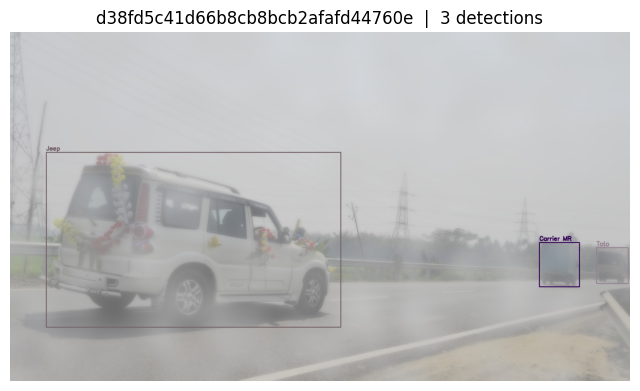

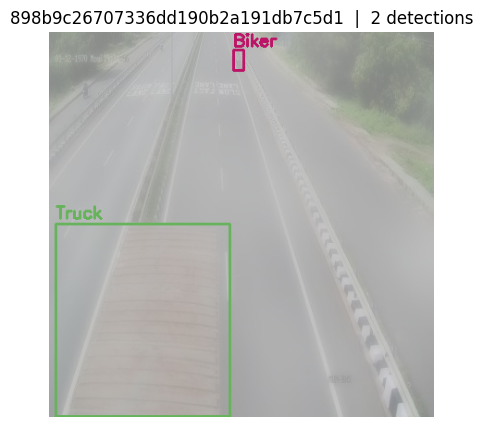

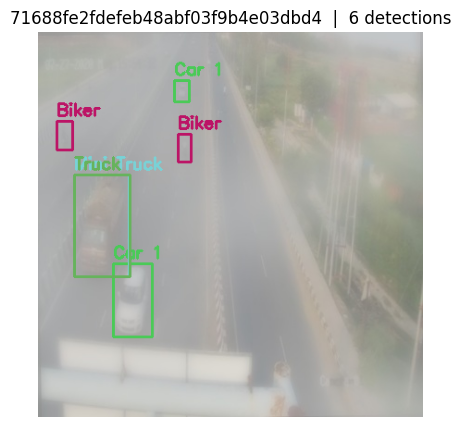

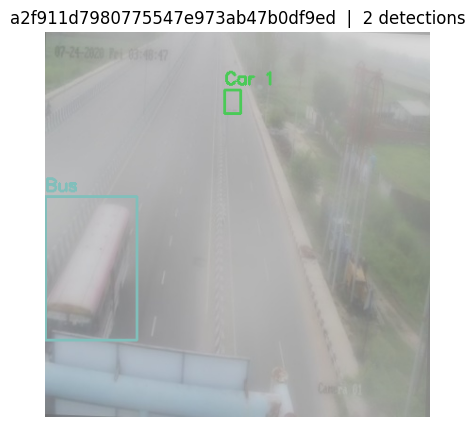

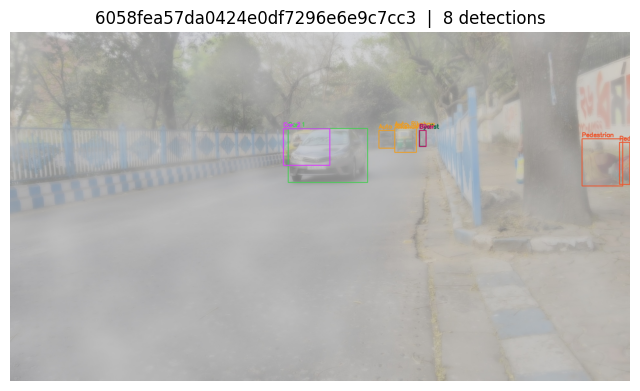

In [ ]:
# Visualzing some random predictions from the submission file to understand the model performance

import random
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Class names (adjust if needed)
CLASS_NAMES = {
    0:"Truck", 1:"Cyclist", 2:"Biker", 3:"Mini Truck", 4:"Car 1",
    5:"Jeep", 6:"Toto", 7:"Carrier MR", 8:"Auto Rikshaw",
    9:"Bus", 10:"Tempo", 11:"Pedal Rikshaw",
    12:"Pedestrian", 13:"Car 2", 14:"Tractor"
}

# Fixed color palette for consistency
np.random.seed(42)
CLASS_COLORS = {
    k: tuple(np.random.randint(0,255,3).tolist())
    for k in CLASS_NAMES
}


def visualize_row(row, img_dir="/content/Test"):
    img_path = f"{img_dir}/{row['Id']}.jpg"
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Image not found: {img_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Handle empty predictions safely
    if pd.isna(row["Classes"]) or row["Classes"] == "":
        plt.figure(figsize=(7,4))
        plt.imshow(img)
        plt.title(f"{row['Id']}  |  NO PREDICTIONS")
        plt.axis("off")
        plt.show()
        return

    classes = list(map(int, row["Classes"].split(",")))
    xs = list(map(float, row["X_center"].split(",")))
    ys = list(map(float, row["Y_center"].split(",")))
    ws = list(map(float, row["Width"].split(",")))
    hs = list(map(float, row["Height"].split(",")))

    for c, x, y, bw, bh in zip(classes, xs, ys, ws, hs):
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)

        color = CLASS_COLORS.get(c, (255,255,255))
        label = CLASS_NAMES.get(c, str(c))

        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(
            img,
            label,
            (x1, max(y1-6, 15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )

    plt.figure(figsize=(8,5))
    plt.imshow(img)
    plt.title(f"{row['Id']}  |  {len(classes)} detections")
    plt.axis("off")
    plt.show()


df = pd.read_csv("task2_final_submission.csv")

sampled_rows = df.sample(5, random_state=random.randint(0, 10_000))

for _, row in sampled_rows.iterrows():
    visualize_row(row)


In [ ]:
from google.colab import files

files.download('task2_final_submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Remarks

This notebook demonstrates a practical, competition-oriented approach to handling extreme domain shift in object detection tasks. By combining physics-inspired fog simulation, careful dataset construction, and metric-aware inference, the solution achieves strong performance under challenging conditions.

The methodology emphasizes:
- Transparency
- Reproducibility
- Engineering discipline over brute-force computation

Further improvements may be explored through fine-grained per-class inference tuning or additional domain-specific augmentations.

Thank you for this challenge SOTA-AI Community.
